In [80]:
import numpy as np
# import torch 
# !pip3 install lightgbm
# !pip3 install xgboost
# !pip3 install catboost
# !pip3 install tqdmt
# from sklearn.metrics import accuracy_score,precision_score,f1_score
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import catboost as cbt
import os
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
import catboost as cbt
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
import gc
import wandb
import time
from wandb.lightgbm import wandb_callback
from sklearn.metrics import roc_auc_score
from collections import defaultdict
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ["SimHei"]
mpl.rcParams["axes.unicode_minus"] = False

In [81]:
root_path = '../datasets/round_2'

train_user_base_info_path = os.path.join(root_path, '训练数据/用户基础信息.csv')
train_user_up_info_path = os.path.join(root_path, '训练数据/用户投稿信息.csv')
train_user_action_info_path = os.path.join(root_path, '训练数据/用户行为信息.csv')
train_user_label_path = os.path.join(root_path, '训练数据/用户标签.csv')

test_user_base_info_path = os.path.join(root_path, '测试数据/用户基础信息.csv')
test_user_up_info_path = os.path.join(root_path, '测试数据/用户投稿信息.csv')
test_user_action_info_path = os.path.join(root_path, '测试数据/用户行为信息.csv')
test_user_label_path = os.path.join(root_path, '测试数据/用户id(无标签).csv')

In [82]:
# 读取原始数据
train_user_base_info = pd.read_csv(train_user_base_info_path)
train_user_up_info = pd.read_csv(train_user_up_info_path)
train_user_action_info = pd.read_csv(train_user_action_info_path)
train_user_label = pd.read_csv(train_user_label_path)

test_user_base_info = pd.read_csv(test_user_base_info_path)
test_user_up_info = pd.read_csv(test_user_up_info_path)
test_user_action_info = pd.read_csv(test_user_action_info_path)
test_user_label = pd.read_csv(test_user_label_path)
test_user_label['label'] = -1

# 级联合并
train_user_base_info = train_user_base_info.merge(train_user_action_info, on = 'id', how = 'left', validate='one_to_one')
train_user_base_info = train_user_base_info.merge(train_user_label, on = 'id', how = 'left', validate='one_to_one')

test_user_base_info = test_user_base_info.merge(test_user_action_info, on = 'id', how = 'left', validate='one_to_one')
test_user_base_info = test_user_base_info.merge(test_user_label, on = 'id', how = 'left', validate='one_to_one')

# 合并训练集与测试集
all_data = pd.concat([train_user_base_info, test_user_base_info], ignore_index=True)

In [83]:
def judge_http(x):
    s = x.split(',')
    le = len(s)
    
    for i in range(le - 8):
        h = s[i]  # h
        t = s[i + 1]  # tt
        p = s[i + 3]  # p
        mao = s[i + 4] # :
        xie = s[i + 5] # /
        
        if h != t and h != p and h!= mao and h!= xie and t !=p and t!=mao and t!=xie and p!=mao and p!=xie and mao!=xie and t == s[i+2] and xie == s[i+6]:
            flag = False
            for j in range(i + 8, le):
                if s[j] == xie:   # http:// 后面能够找到一个 /
                    return True, [h, t, t, p, mao, xie, xie]
    return False, []

def judge_https(x):
    s = x.split(',')
    le = len(s)
    
    for i in range(le - 9):
        h = s[i]  # h
        t = s[i + 1]  # tt
        p = s[i + 3]  # p
        ais = s[i + 4] # s
        mao = s[i + 5] # :
        xie = s[i + 6] # /
        
        if h != t and h != p and h!=ais and h!= mao and h!= xie and t !=p and t!=ais and t!=mao and t!=xie and p!=ais and p!=mao and p!=xie and ais!=mao and ais!=xie and mao!=xie and t == s[i+2] and xie == s[i+7]:
            flag = False
            for j in range(i + 9, le):
                if s[j] == xie:   # http:// 后面能够找到一个 /
                    return True, [h, t, t, p, ais, mao, xie, xie]
    return False, []

a = defaultdict(int)
aa = defaultdict(int)
for idx, i in enumerate(train_user_up_info['item_title']):
    i = str(i)
    res = judge_http(i)
    res2 = judge_https(i)
    if res[0]:
        http = ','.join(res[1])
        a[http] += 1
        # print('{} --> [{}] --> {}'.format(idx, ','.join(res[1]), i))
    
#     if idx > 300000:
#         break
    if res2[0]:
        https = ','.join(res2[1])
        aa[https] += 1

b = list(a.items())
b.sort(key=lambda x: -x[1])
for tag, count in b:
    if count > 1:
        print('http:// --> {} --> {}'.format(tag, count))
print('-------------------')


bb = list(aa.items())
bb.sort(key=lambda x: -x[1])
for tag, count in bb:
    if count > 1:
        print('https:// --> {} --> {}'.format(tag, count))
print('-------------------')

http:// --> 3672,7750,7750,10810,1925,4628,4628 --> 17
http:// --> 4864,6128,6128,10690,1566,4669,4669 --> 11
http:// --> 2189,7579,7579,4010,1712,7571,7571 --> 6
http:// --> 1868,952,952,9210,8434,1217,1217 --> 5
http:// --> 1868,10690,10690,5461,301,1217,1217 --> 3
http:// --> 1566,4669,4669,3672,3471,1897,1897 --> 3
http:// --> 4302,10626,10626,1712,3672,3697,3697 --> 3
http:// --> 4107,3857,3857,3672,11079,1019,1019 --> 3
http:// --> 4607,3672,3672,5767,10266,5452,5452 --> 3
http:// --> 8953,1065,1065,10690,4269,3672,3672 --> 3
http:// --> 9094,972,972,7106,8433,3672,3672 --> 2
http:// --> 10504,3864,3864,301,2229,2574,2574 --> 2
http:// --> 1806,10261,10261,7708,3672,782,782 --> 2
-------------------
https:// --> 2189,7579,7579,4010,1385,1712,7571,7571 --> 47
https:// --> 8434,1217,1217,3672,4612,4936,8342,8342 --> 4
https:// --> 7551,859,859,4580,3672,4612,7045,7045 --> 3
https:// --> 7137,7855,7855,301,3621,4302,6224,6224 --> 3
https:// --> 258,9689,9689,4597,1385,2859,6294,6294

In [84]:
for i in all_data.columns:
    print(i, ': ', sum(all_data[i].isna()), ' --> ', all_data[i].dtype)

id :  0  -->  int64
gender_str :  0  -->  object
signature :  29252  -->  object
create_time :  0  -->  int64
follow_num_all :  0  -->  int64
fans_num_all :  0  -->  int64
publish_cnt_all :  0  -->  int64
server_comment_cnt_all :  0  -->  int64
video_play :  2252  -->  float64
video_play_finish :  2252  -->  float64
play_time :  2252  -->  float64
click_video_play :  2252  -->  float64
feed_request :  2252  -->  float64
homepage_hot_slide_up :  2252  -->  float64
homepage_hot_slide_down :  2252  -->  float64
like :  2252  -->  float64
dislike :  2252  -->  float64
post_comment :  2252  -->  float64
search :  2252  -->  float64
share_video :  2252  -->  float64
label :  0  -->  int64


In [85]:
print('训练集总量：', len(train_user_base_info))
print('测试集总量：', len(test_user_base_info))
print('数据集总量：', len(all_data))

print('\n训练集 label 1/0 占比：')
(train_user_base_info['label'].value_counts() / len(train_user_base_info))

训练集总量： 62433
测试集总量： 44995
数据集总量： 107428

训练集 label 1/0 占比：


0    0.826967
1    0.173033
Name: label, dtype: float64

In [86]:
all_data.head(10)

,id,gender_str,signature,create_time,follow_num_all,fans_num_all,publish_cnt_all,server_comment_cnt_all,video_play,video_play_finish,...,click_video_play,feed_request,homepage_hot_slide_up,homepage_hot_slide_down,like,dislike,post_comment,search,share_video,label
0,44630,male,NaN,1546356215,115,149,6,44,1641.0,504.0,...,56.0,0.0,1606.0,12.0,1.0,0.0,0.0,10.0,0.0,0
1,45278,male,NaN,1570359009,561,168,58,216,1762.0,44.0,...,336.0,0.0,630.0,51.0,195.0,0.0,1.0,1.0,0.0,1
2,27216,female,"890,5036,113,11018,1065,11018,113,728,4214,372...",1610200855,37,74,112,520,787.0,278.0,...,205.0,0.0,493.0,24.0,22.0,0.0,3.0,11.0,1.0,0
3,100024,female,"3423,498,4833,8246,4560,10729,2959,4560",1625416723,0,21,1,0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,237043,female,"113,4333,8953,10690,4214,3720,4214,4333,4333,1...",1520244809,7,806,1498,693,779.0,92.0,...,108.0,0.0,216.0,30.0,10.0,0.0,0.0,0.0,0.0,0
5,57700,male,"10573,1296,8450,1498,3976,8729,9803,301,3526,1...",1510006711,1257,173,248,3011,675.0,180.0,...,41.0,0.0,337.0,24.0,17.0,0.0,22.0,0.0,2.0,0
6,281429,female,"8245,2154,11069,3672,2435,1039,11069,301,9029,...",1526985742,1106,1836,1662,2863,880.0,188.0,...,6.0,0.0,381.0,39.0,60.0,0.0,10.0,0.0,0.0,0
7,62619,female,"3471,2799,10832,301,10504,133,9094,4640,5695,3...",1542419583,157,63,341,202,551.0,130.0,...,52.0,0.0,522.0,6.0,1.0,0.0,0.0,1.0,0.0,0
8,80689,female,NaN,1623898172,1335,1109,5,0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,1
9,21375,male,"4599,5139,4739,7565,711,4552,3116,89,11137,102...",1600867508,108,89737,314,4007,1164.0,198.0,...,7.0,0.0,917.0,17.0,31.0,0.0,46.0,2.0,3.0,0


## 将日期时间戳拆解为年月日小时

In [87]:
def cal_time_feature(df, feature_names):
    for name in feature_names:
        df[name + "_year"] = pd.to_datetime(df[name], unit='s').dt.year  # 年
        df[name + "_month"] = pd.to_datetime(df[name], unit='s').dt.month  # 月
        df[name + "_day"] = pd.to_datetime(df[name], unit='s').dt.day  # 日
        df[name + "_weekday"] = pd.to_datetime(df[name], unit='s').dt.weekday  # 星期
        df[name + "_hour"] = pd.to_datetime(df[name], unit='s').dt.hour  # 小时
    for i in range(len(feature_names)):
        for j in range(i + 1, len(feature_names)):
            df[feature_names[i] + feature_names[j] + '_days_diff'] = (pd.to_datetime(df[feature_names[i]]) - pd.to_datetime(df[feature_names[j]])).apply(lambda x: x.days)
#             month_1 = pd.to_datetime(df[feature_names[i]]).dt.year * 12 + pd.to_datetime(df[feature_names[i]]).dt.month
#             month_2 = pd.to_datetime(df[feature_names[j]]).dt.year * 12 + pd.to_datetime(df[feature_names[j]]).dt.month
#             df[feature_names[i].replace("date", "") + feature_names[j].replace("date", "") + 'month_diff'] = month_1 - month_2
#             df[feature_names[i].replace("date", "") + feature_names[j].replace("date", "") + 'year_diff'] = pd.to_datetime(df[feature_names[i]]).dt.year - pd.to_datetime(df[feature_names[j]]).dt.year
    return df

In [88]:
all_data = cal_time_feature(all_data.copy(), ['create_time'])
all_data

,id,gender_str,signature,create_time,follow_num_all,fans_num_all,publish_cnt_all,server_comment_cnt_all,video_play,video_play_finish,...,dislike,post_comment,search,share_video,label,create_time_year,create_time_month,create_time_day,create_time_weekday,create_time_hour
0,44630,male,NaN,1546356215,115,149,6,44,1641.0,504.0,...,0.0,0.0,10.0,0.0,0,2019,1,1,1,15
1,45278,male,NaN,1570359009,561,168,58,216,1762.0,44.0,...,0.0,1.0,1.0,0.0,1,2019,10,6,6,10
2,27216,female,"890,5036,113,11018,1065,11018,113,728,4214,372...",1610200855,37,74,112,520,787.0,278.0,...,0.0,3.0,11.0,1.0,0,2021,1,9,5,14
3,100024,female,"3423,498,4833,8246,4560,10729,2959,4560",1625416723,0,21,1,0,3.0,0.0,...,0.0,0.0,1.0,0.0,1,2021,7,4,6,16
4,237043,female,"113,4333,8953,10690,4214,3720,4214,4333,4333,1...",1520244809,7,806,1498,693,779.0,92.0,...,0.0,0.0,0.0,0.0,0,2018,3,5,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107423,137771,female,"8382,7053,1035,6594,7012",1566734517,1999,1152,292,6575,247.0,83.0,...,0.0,13.0,0.0,0.0,-1,2019,8,25,6,12
107424,94864,female,"113,4214,4214,113,11018,728,1065,728,5324,1065",1543319037,1358,579,2408,15788,16874.0,914.0,...,2.0,425.0,2.0,25.0,-1,2018,11,27,1,11
107425,6285,female,"4857,1117,2574,10086,301,5864,4552,5132,9782,3...",1499176652,135,377,1571,335,207.0,58.0,...,0.0,1.0,4.0,0.0,-1,2017,7,4,1,13
107426,20581,male,"8342,2435,4870,6141,301,4552,8015,5735,8389,0,...",1522723423,178,66,318,570,2660.0,727.0,...,3.0,1.0,52.0,0.0,-1,2018,4,3,1,2


## 添加是否包含 http / https 的标志

In [89]:
all_data['signature'].fillna('', inplace=True)

In [90]:
def is_contain_url(x):
    https_str = '2189,7579,7579,4010,1385,1712,7571,7571'
    http_str = '2189,7579,7579,4010,1712,7571,7571'
    return x.count(http_str) + x.count(https_str)

#     if https_str in x:
#         # https
#         return 1
#     if http_str in x:
#         # http
#         return 1
#     return 0

all_data['is_signature_contain_url'] = all_data['signature'].fillna('').map(is_contain_url)

In [91]:
def get_title_length(x):
    if x is None or len(x.strip(',')) == 0:
        return 0
    return len(x.split(','))

all_data['is_signature_null'] = (all_data['signature'].map(get_title_length) == 0).astype(int)
# all_data['signature_length'] = all_data['signature'].fillna('').map(get_title_length)

In [92]:
all_data

,id,gender_str,signature,create_time,follow_num_all,fans_num_all,publish_cnt_all,server_comment_cnt_all,video_play,video_play_finish,...,search,share_video,label,create_time_year,create_time_month,create_time_day,create_time_weekday,create_time_hour,is_signature_contain_url,is_signature_null
0,44630,male,,1546356215,115,149,6,44,1641.0,504.0,...,10.0,0.0,0,2019,1,1,1,15,0,1
1,45278,male,,1570359009,561,168,58,216,1762.0,44.0,...,1.0,0.0,1,2019,10,6,6,10,0,1
2,27216,female,"890,5036,113,11018,1065,11018,113,728,4214,372...",1610200855,37,74,112,520,787.0,278.0,...,11.0,1.0,0,2021,1,9,5,14,0,0
3,100024,female,"3423,498,4833,8246,4560,10729,2959,4560",1625416723,0,21,1,0,3.0,0.0,...,1.0,0.0,1,2021,7,4,6,16,0,0
4,237043,female,"113,4333,8953,10690,4214,3720,4214,4333,4333,1...",1520244809,7,806,1498,693,779.0,92.0,...,0.0,0.0,0,2018,3,5,0,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107423,137771,female,"8382,7053,1035,6594,7012",1566734517,1999,1152,292,6575,247.0,83.0,...,0.0,0.0,-1,2019,8,25,6,12,0,0
107424,94864,female,"113,4214,4214,113,11018,728,1065,728,5324,1065",1543319037,1358,579,2408,15788,16874.0,914.0,...,2.0,25.0,-1,2018,11,27,1,11,0,0
107425,6285,female,"4857,1117,2574,10086,301,5864,4552,5132,9782,3...",1499176652,135,377,1571,335,207.0,58.0,...,4.0,0.0,-1,2017,7,4,1,13,0,0
107426,20581,male,"8342,2435,4870,6141,301,4552,8015,5735,8389,0,...",1522723423,178,66,318,570,2660.0,727.0,...,52.0,0.0,-1,2018,4,3,1,2,0,0


## 将 user up info 加到 all_data 中

In [93]:
def count_categorical(df, group_var, df_name, sparse_columns):
    # 提取离散型变量
    data = df[sparse_columns].astype('str')
    
    # categorical = pd.get_dummies(data)
    agg_list = ['nunique']
    categorical = data
    categorical[group_var] = df[group_var]
    column_names = []
    div_column_names = []   # agg 操作占总的比例，列名
    
    if len(group_var) != len(sparse_columns):
        # 假如 group_var 和 sparse_columns 长度相等，认为此时用所有的 sparse 字段进行 group
        categorical = categorical.groupby(group_var).agg(agg_list)
        for var in categorical.columns.levels[0]:
            for stat in agg_list:
                column_names.append('%s_%s_%s' % (df_name, var, stat))

                # 尝试在 group 中让离散列的 nunique 除以该列总的 nunique（比如，一个人购买的商品里占了总商品的多少占比。）
    #             categorical['{}_{}_{}/all'.format(df_name, var, stat)] = categorical[(var, stat)] / df[var].agg(stat)
    #             div_column_names.append('{}_{}_{}/all'.format(df_name, var, stat))
    else:
        # 在使用所有字段进行 group 时，agg nunique 会产生 no_results
        categorical = categorical.groupby(group_var).count()
        
    column_names.extend(div_column_names)
    
    # 加上 count 列
    group_count_column = df.groupby(group_var)[group_var[0]].agg(['count'])
    
    # 若 group_var 有多列，则增加 group_var / 其中某列的 group 信息
    if len(group_var) > 1:
        for var in group_var:
            var_count = df.groupby(var)[var].agg(['count'])
            group_count_column['({})_count/{}_count'.format(','.join(group_var), var)] = group_count_column['count'] / var_count['count']

    group_count_column.columns = [df_name + '_' + i for i in group_count_column.columns]

    categorical = categorical.merge(group_count_column, on=group_var, how='left')
    column_names.extend(group_count_column.columns)
    # column_names.append('{}_count'.format('_'.join(group_var)))
    
#     print(column_names)
#     print(group_count_column.columns)
#     print(categorical)
    
    categorical.columns = column_names

#     print(categorical)
    
    return categorical


def count_dense_columns(df, group_var, df_name, dense_columns, agg_list=None):
    # 提取连续型变量
    data = df[dense_columns].astype('float')
    
    # categorical = pd.get_dummies(data)
    if agg_list is None:
        agg_list = [
            'median',
            'mean',
            'max',
            'min',
            'sum',
            'var',
            'std'
        ]
    dense_features = data
    dense_features[group_var] = df[group_var]
    
    dense_features = dense_features.groupby(group_var).agg(agg_list)
    
    column_names = []
    for var in dense_features.columns.levels[0]:
        for stat in agg_list:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    dense_features.columns = column_names

    return dense_features

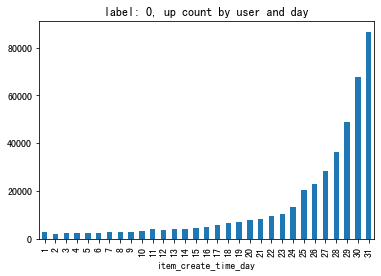

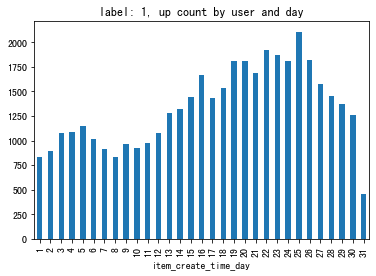

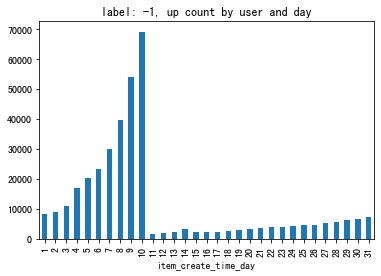

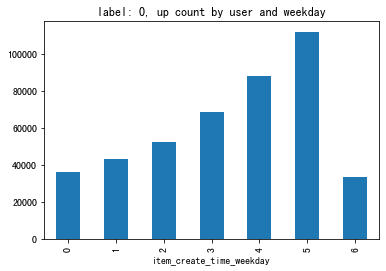

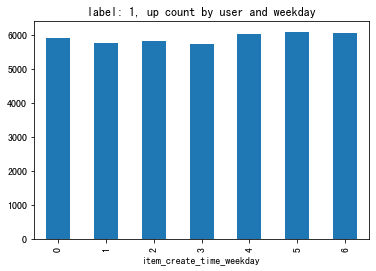

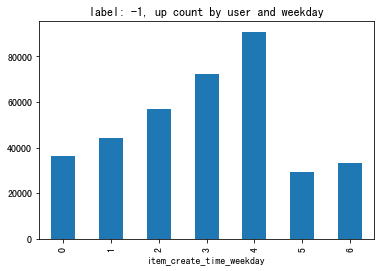

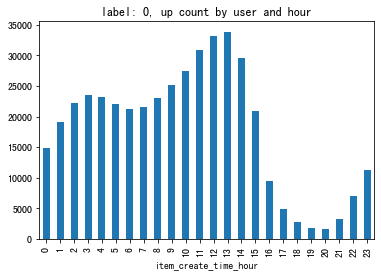

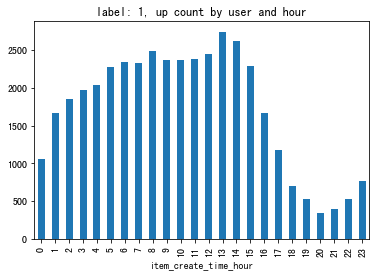

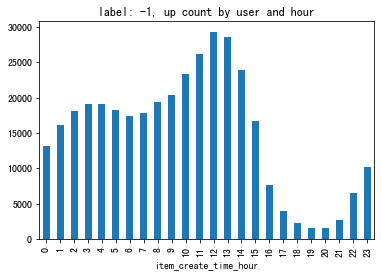

In [94]:
# 用户投稿日期在训练集与测试集中的正负样本分布情况
for time_span in [
      # 'year',
      # 'month',
      'day',
      'weekday',
      'hour'
]:
    for user_up_info, user_label in [(train_user_up_info, train_user_label), (test_user_up_info, test_user_label)]:
        a = cal_time_feature(user_up_info.copy(), ['item_create_time']).merge(user_label, on='id', how='left')
#         pd.pivot_table(a, index=[f'item_create_time_{time_span}'], aggfunc='count')['item_create_time'].plot.bar(title='zong de')
#         plt.show()
        data = pd.pivot_table(a, index=[f'item_create_time_{time_span}'], columns=['label'], aggfunc='count')['item_create_time']#.plot.bar(title=f'up count by user and {time_span}')
        for column in data.columns:
            data[column].plot.bar(title=f'label: {column}, up count by user and {time_span}')
#             print(data)
#             sns.barplot(x=f'label', data=data)
            plt.show()

In [95]:
# cal_time_feature(train_user_up_info.copy(), ['item_create_time'])['item_create_time_year'].value_counts().sort_index().plot.bar()
# cal_time_feature(train_user_up_info.copy(), ['item_create_time'])['item_create_time_month'].value_counts().sort_index().plot.bar()
# cal_time_feature(train_user_up_info.copy(), ['item_create_time'])['item_create_time_day'].value_counts().sort_index().plot.bar()

#cal_time_feature(test_user_up_info.copy(), ['item_create_time'])['item_create_time_month'].value_counts().sort_index().plot.bar()

# a = cal_time_feature(train_user_up_info.copy(), ['item_create_time']).merge(train_user_label, on=['id'], how='left')[['label', 'id', 'item_create_time_month']]
# pd.pivot_table(a, index=['item_create_time_month'], columns=['label'] ,aggfunc='count').fillna(0.0).plot.bar()

# all_data
# a = all_data.copy()
# # a['label'] = a['label'] == -1
# pd.pivot_table(a, index=['create_time_year'], columns=['label'], aggfunc='count').fillna(0.0)['click_video_play'].plot.bar()

In [96]:
def construct_user_up_info(df):
    # 构造用户上传信息
#     df_with_date = df.copy()
    df_with_date = cal_time_feature(df.copy(), ['item_create_time'])
    
    # 加一列是视频标题里是否包含链接
    df_with_date['is_item_title_contain_url'] = df_with_date['item_title'].fillna('').map(is_contain_url)
    # 加一列标题的长度
#     df_with_date['item_title_length'] = df_with_date['item_title'].fillna('').map(get_title_length)
    df_with_date['is_item_title_null'] = (df_with_date['item_title'].fillna('').map(get_title_length) == 0).astype(int)
    df_with_date['is_poi_name_null'] = (df_with_date['poi_name'].fillna('').map(get_title_length) == 0).astype(int)

    # tmp_features = df_with_date.copy()

    unique_features = count_categorical(df_with_date, group_var=['id'], df_name='sparse:user_up_info:group_val_(id)', sparse_columns=['item_title',
                                                                                                                                      'poi_name',
                                                                                                                                      'item_province_cn',
                                                                                                                                     ])
    # tmp_features = tmp_features.merge(unique_features, on=['id'], how='left', validate='many_to_one')

    dense_features = count_dense_columns(df_with_date, group_var=['id'], df_name='dense:user_up_info:group_val_(id)', dense_columns=[
                                                                                              'item_create_time',
                                                                                              'is_item_title_contain_url',
                                                                                              'is_item_title_null',
                                                                                              'is_poi_name_null',
#                                                                                               'item_title_length',
#                                                                                               'item_create_time_year',
#                                                                                               'item_create_time_month',
#                                                                                               'item_create_time_day',
#                                                                                               'item_create_time_weekday',
#                                                                                               'item_create_time_hour'
    ])

    dense_features['dense:user_up_info:group_val_(id)_item_create_time_(max-min)/count'] = (dense_features['dense:user_up_info:group_val_(id)_item_create_time_max'] - dense_features['dense:user_up_info:group_val_(id)_item_create_time_min']) / unique_features['sparse:user_up_info:group_val_(id)_count']
    dense_features['dense:user_up_info:group_val_(id)_item_create_time_(max-min)'] = (dense_features['dense:user_up_info:group_val_(id)_item_create_time_max'] - dense_features['dense:user_up_info:group_val_(id)_item_create_time_min'])
    dense_features = dense_features[['dense:user_up_info:group_val_(id)_item_create_time_var',
                                    'dense:user_up_info:group_val_(id)_item_create_time_std',
                                    'dense:user_up_info:group_val_(id)_item_create_time_(max-min)/count',
                                    'dense:user_up_info:group_val_(id)_item_create_time_(max-min)',
                                     
                                   'dense:user_up_info:group_val_(id)_is_item_title_contain_url_median',
                                   'dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean',
                                   'dense:user_up_info:group_val_(id)_is_item_title_contain_url_max',
                                   'dense:user_up_info:group_val_(id)_is_item_title_contain_url_min',
                                   'dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum',
                                   'dense:user_up_info:group_val_(id)_is_item_title_contain_url_var',
                                   'dense:user_up_info:group_val_(id)_is_item_title_contain_url_std',
                                     
                                   'dense:user_up_info:group_val_(id)_is_item_title_null_median',
                                   'dense:user_up_info:group_val_(id)_is_item_title_null_mean',
                                   'dense:user_up_info:group_val_(id)_is_item_title_null_max',
                                   'dense:user_up_info:group_val_(id)_is_item_title_null_min',
                                   'dense:user_up_info:group_val_(id)_is_item_title_null_sum',
                                   'dense:user_up_info:group_val_(id)_is_item_title_null_var',
                                   'dense:user_up_info:group_val_(id)_is_item_title_null_std',
                                   'dense:user_up_info:group_val_(id)_is_poi_name_null_median',
                                   'dense:user_up_info:group_val_(id)_is_poi_name_null_mean',
                                   'dense:user_up_info:group_val_(id)_is_poi_name_null_max',
                                   'dense:user_up_info:group_val_(id)_is_poi_name_null_min',
                                   'dense:user_up_info:group_val_(id)_is_poi_name_null_sum',
                                   'dense:user_up_info:group_val_(id)_is_poi_name_null_var',
                                   'dense:user_up_info:group_val_(id)_is_poi_name_null_std',
                                     
#                                    'dense:user_up_info:group_val_(id)_item_title_length_median',
#                                    'dense:user_up_info:group_val_(id)_item_title_length_mean',
#                                    'dense:user_up_info:group_val_(id)_item_title_length_max',
#                                    'dense:user_up_info:group_val_(id)_item_title_length_min',
#                                    'dense:user_up_info:group_val_(id)_item_title_length_sum',
#                                    'dense:user_up_info:group_val_(id)_item_title_length_var',
#                                    'dense:user_up_info:group_val_(id)_item_title_length_std',
                                    
#                                    'dense:user_up_info:group_val_(id)_item_create_time_weekday_median',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_weekday_mean',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_weekday_max',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_weekday_min',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_weekday_sum',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_weekday_var',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_weekday_std',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_hour_median',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_hour_mean',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_hour_max',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_hour_min',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_hour_sum',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_hour_var',
#                                    'dense:user_up_info:group_val_(id)_item_create_time_hour_std',
                                    ]]

    dense_features.fillna(0.0, inplace=True)

    # tmp_features = tmp_features.merge(dense_features, on=['id'], how='left', validate='many_to_one')
    # tmp_features
    tmp_features = unique_features.merge(dense_features, on=['id'], how='left', validate='one_to_one').reset_index()
    return tmp_features

train_user_up_tmp = construct_user_up_info(train_user_up_info.copy())
test_user_up_tmp = construct_user_up_info(test_user_up_info.copy())

new_train_info = all_data[all_data['label'] != -1].merge(train_user_up_tmp, on=['id'], how='left', validate='one_to_one')
new_test_info = all_data[all_data['label'] == -1].merge(test_user_up_tmp, on=['id'], how='left', validate='one_to_one')
all_data = pd.concat([new_train_info, new_test_info], ignore_index=True)

for i in all_data.columns:
    if all_data[i].dtype == float:
        all_data[i].fillna(0.0, inplace=True)
    elif all_data[i].dtype == 'object':
        all_data[i].fillna('nan', inplace=True)
    elif all_data[i].dtype == 'int':
        all_data[i].fillna(0, inplace=True)
    print(i, sum(all_data[i].isna()), all_data[i].dtype)

id 0 int64
gender_str 0 object
signature 0 object
create_time 0 int64
follow_num_all 0 int64
fans_num_all 0 int64
publish_cnt_all 0 int64
server_comment_cnt_all 0 int64
video_play 0 float64
video_play_finish 0 float64
play_time 0 float64
click_video_play 0 float64
feed_request 0 float64
homepage_hot_slide_up 0 float64
homepage_hot_slide_down 0 float64
like 0 float64
dislike 0 float64
post_comment 0 float64
search 0 float64
share_video 0 float64
label 0 int64
create_time_year 0 int64
create_time_month 0 int64
create_time_day 0 int64
create_time_weekday 0 int64
create_time_hour 0 int64
is_signature_contain_url 0 int64
is_signature_null 0 int64
sparse:user_up_info:group_val_(id)_item_title_nunique 0 float64
sparse:user_up_info:group_val_(id)_poi_name_nunique 0 float64
sparse:user_up_info:group_val_(id)_item_province_cn_nunique 0 float64
sparse:user_up_info:group_val_(id)_count 0 float64
dense:user_up_info:group_val_(id)_item_create_time_var 0 float64
dense:user_up_info:group_val_(id)_item

### TF-IDF 将个签和标题中最重要的关键字提取出来

In [97]:
all_data

,id,gender_str,signature,create_time,follow_num_all,fans_num_all,publish_cnt_all,server_comment_cnt_all,video_play,video_play_finish,...,dense:user_up_info:group_val_(id)_is_item_title_null_sum,dense:user_up_info:group_val_(id)_is_item_title_null_var,dense:user_up_info:group_val_(id)_is_item_title_null_std,dense:user_up_info:group_val_(id)_is_poi_name_null_median,dense:user_up_info:group_val_(id)_is_poi_name_null_mean,dense:user_up_info:group_val_(id)_is_poi_name_null_max,dense:user_up_info:group_val_(id)_is_poi_name_null_min,dense:user_up_info:group_val_(id)_is_poi_name_null_sum,dense:user_up_info:group_val_(id)_is_poi_name_null_var,dense:user_up_info:group_val_(id)_is_poi_name_null_std
0,44630,male,,1546356215,115,149,6,44,1641.0,504.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,45278,male,,1570359009,561,168,58,216,1762.0,44.0,...,10.0,0.000000,0.000000,1.0,1.0,1.0,1.0,10.0,0.0,0.000000
2,27216,female,"890,5036,113,11018,1065,11018,113,728,4214,372...",1610200855,37,74,112,520,787.0,278.0,...,1.0,0.100000,0.316228,1.0,1.0,1.0,1.0,10.0,0.0,0.000000
3,100024,female,"3423,498,4833,8246,4560,10729,2959,4560",1625416723,0,21,1,0,3.0,0.0,...,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.000000
4,237043,female,"113,4333,8953,10690,4214,3720,4214,4333,4333,1...",1520244809,7,806,1498,693,779.0,92.0,...,10.0,0.000000,0.000000,1.0,1.0,1.0,1.0,10.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107423,137771,female,"8382,7053,1035,6594,7012",1566734517,1999,1152,292,6575,247.0,83.0,...,2.0,0.177778,0.421637,1.0,1.0,1.0,1.0,10.0,0.0,0.000000
107424,94864,female,"113,4214,4214,113,11018,728,1065,728,5324,1065",1543319037,1358,579,2408,15788,16874.0,914.0,...,10.0,0.000000,0.000000,1.0,1.0,1.0,1.0,10.0,0.0,0.000000
107425,6285,female,"4857,1117,2574,10086,301,5864,4552,5132,9782,3...",1499176652,135,377,1571,335,207.0,58.0,...,2.0,0.177778,0.421637,1.0,1.0,1.0,1.0,10.0,0.0,0.000000
107426,20581,male,"8342,2435,4870,6141,301,4552,8015,5735,8389,0,...",1522723423,178,66,318,570,2660.0,727.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [98]:
# 抽取用户个性标签以及所有上传的视频标题
def extract_user_signature_and_all_item_title(user_base_info, user_up_info):
    sep_concat_up_info = user_up_info.groupby('id')['item_title'].apply(lambda x: x.str.cat(sep=',')).reset_index()
    base_info_with_title = sep_concat_up_info.merge(user_base_info, on=['id'], how='left', validate='one_to_one')[['id', 'signature', 'item_title']]
    base_info_with_title = base_info_with_title.fillna('')

    base_info_with_title['sig_with_title'] = (base_info_with_title['signature'] + ',' + base_info_with_title['item_title']).map(lambda x: x.strip(','))
    return base_info_with_title

# 抽取信息并拼接
train_user_sig_with_title = extract_user_signature_and_all_item_title(train_user_base_info, train_user_up_info)
test_user_sig_with_title = extract_user_signature_and_all_item_title(test_user_base_info, test_user_up_info)

# 和 label 拼起来（id 在训练集和测试集之间不唯一），为了合并后一起处理完再与 all_data 合并
train_user_sig_with_title = train_user_sig_with_title.merge(train_user_label, on='id', how='left', validate='one_to_one')
test_user_sig_with_title = test_user_sig_with_title.merge(test_user_label, on='id', how='left', validate='one_to_one')
all_user_sig_with_title = pd.concat([train_user_sig_with_title, test_user_sig_with_title], ignore_index=True)

In [99]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

del_char_list = []  # 预先删除的字符
lac_seg_res = [[j for j in i.split(',') if j not in del_char_list] if len(i.strip()) !=0 else [] for i in all_user_sig_with_title['sig_with_title'].values]  # 所有的 corpus 分词的结果
seg_corpus = [' '.join(i) for i in lac_seg_res] # 分词结果用空格拼接

vectorizer = CountVectorizer(#max_df=1 #0.000013
                            ) #该类会将文本中的词语转换为词频矩阵，矩阵元素 a[i][j] 表示 j 词在 i 类文本下的词频  
transformer = TfidfTransformer() # 该类会统计每个词语的 tf-idf 权值
tfidf = transformer.fit_transform(vectorizer.fit_transform(seg_corpus)) #第一个 fit_transform 是计算 tf-idf，第二个 fit_transform 是将文本转为词频矩阵  
word = vectorizer.get_feature_names() #获取词袋模型中的所有词语  
#weight = tfidf.toarray() #将 tf-idf 矩阵抽取出来，元素 a[i][j] 表示 j 词在 i 类文本中的 tf-idf 权重  

#weight.shape
# for i in range(len(weight)):#打印每类文本的tf-idf词语权重，第一个for遍历所有文本，第二个for便利某一类文本下的词语权重  
#     print(u"-------这里输出第",i,u"类文本的词语tf-idf权重------")
#     for j in range(len(word)):  
#         print (word[j],weight[i][j])
#     break
detail_to_lac_keyword = dict()

for i in range(len(lac_seg_res)):
    sentences_matrix = tfidf[i].toarray()
    
    # max_idx = sentences_matrix.argmax()
    max_idx = np.argsort(sentences_matrix[0])[::-1]
    
    # 选取 tfidf 最大的前 3 个
    keywords = {'tfidf_keyword_{}'.format(idx_count):
                 (word[max_idx[idx_count]]
                  if idx_count < len(lac_seg_res[i])
                  else '')
                 for idx_count in range(3)}
    detail_to_lac_keyword[i] = keywords
        
        
#     top1_keyword = word[max_idx[0]] if len(max_idx) >= 1 else ''
#     top2_keyword = word[max_idx[1]] if len(max_idx) >= 2 else ''
#     top3_keyword = word[max_idx[2]] if len(max_idx) >= 3 else ''
    
#     detail_to_lac_keyword[i] = {
#         'tfidf_keyword': top1_keyword,
#         'tfidf_keyword_2': top2_keyword,
#         'tfidf_keyword_3': top3_keyword,
#         # 'lac_tfidf_score': sentences_matrix[0][max_idx],    # 加了效果降低了 0.0005
#     }

post_detail_to_lac_keyword_pd = pd.DataFrame.from_dict(detail_to_lac_keyword, orient='index')
post_detail_to_lac_keyword_pd#.head(5)

,tfidf_keyword_0,tfidf_keyword_1,tfidf_keyword_2
0,,,
1,3620,9025,6716
2,4213,11007,2648
3,8302,3769,6710
4,3672,9210,301
...,...,...,...
102765,11018,318,3450
102766,6043,301,6252
102767,3672,2754,3497
102768,9699,8138,6199


In [100]:
all_user_sig_with_title[post_detail_to_lac_keyword_pd.columns] = post_detail_to_lac_keyword_pd
all_user_sig_with_title

,id,signature,item_title,sig_with_title,label,tfidf_keyword_0,tfidf_keyword_1,tfidf_keyword_2
0,5,,,,1,,,
1,19,,"4612,6650,1868,3620,7281,9094,9025,6716,1903,9...","4612,6650,1868,3620,7281,9094,9025,6716,1903,9...",0,3620,9025,6716
2,41,"3593,6247,7776,6848,10329,7841,6039,6298,9400,...","4612,11007,2648,7565,6822,3735,3672,4612,3976,...","3593,6247,7776,6848,10329,7841,6039,6298,9400,...",1,4213,11007,2648
3,43,"3894,5304,8302,662,3236,4125,0,3894,3972,495,4...","4612,6710,8302,3769,3672,7111,10728,1752,5645,...","3894,5304,8302,662,3236,4125,0,3894,3972,495,4...",0,8302,3769,6710
4,45,"10504,55,4494,9210,7053,6597,2229,2574,2229,33...","10679,7708,1117,1439,9210,5695,9514,65,1238,55...","10504,55,4494,9210,7053,6597,2229,2574,2229,33...",0,3672,9210,301
...,...,...,...,...,...,...,...,...
102765,307336,"1897,3450,750,318,113,4214,8953,728,3720,11018...","4494,1752,7915,113,89,4192,1439,9112,2156,4109","1897,3450,750,318,113,4214,8953,728,3720,11018...",-1,11018,318,3450
102766,307339,"3138,4168,7281,4003,9411,3672,113,8953,8953,10...","4612,5695,5640,10103,5695,5623,8450,3672,4612,...","3138,4168,7281,4003,9411,3672,113,8953,8953,10...",-1,6043,301,6252
102767,307343,"10832,8366,1796,9393,9210,4132,8538,1217,6337,...","3471,7565,9210,4012,4638,6039,55,6039,4358,766...","10832,8366,1796,9393,9210,4132,8538,1217,6337,...",-1,3672,2754,3497
102768,307352,"10504,9725,1837,8790,9350,2754,1868,3517,298,3...","3018,642,4156,642,8138,2156,8434,301,6650,6090...","10504,9725,1837,8790,9350,2754,1868,3517,298,3...",-1,9699,8138,6199


In [101]:
char_id = '301'

fz = sum(all_user_sig_with_title[all_user_sig_with_title['tfidf_keyword_0'] == char_id]['label'] == 1)
fm = sum(all_user_sig_with_title[all_user_sig_with_title['tfidf_keyword_0'] == char_id]['label'] != -1)
print('{}/{} = {}'.format(fz, fm, fz / fm))
all_user_sig_with_title[all_user_sig_with_title['tfidf_keyword_0'] == char_id]

196/4675 = 0.04192513368983957


,id,signature,item_title,sig_with_title,label,tfidf_keyword_0,tfidf_keyword_1,tfidf_keyword_2
14,79,,"10352,7191,10504,316,2000,9725,5695,9210,7012,...","10352,7191,10504,316,2000,9725,5695,9210,7012,...",0,301,6683,5511
18,85,"8944,8382,2699,5578,10520,1630,0,7141,2508,838...","6747,10261,2435,1868,3793,2687,301,55,6039,171...","8944,8382,2699,5578,10520,1630,0,7141,2508,838...",0,301,1025,6039
26,111,"8342,301,2574,301,10440,6039,6650,5332,6279","6597,3450,2587,4612,6650,10440,6039,2102,4031,...","8342,301,2574,301,10440,6039,6650,5332,6279,65...",0,301,5009,9094
42,189,"3199,4368,9491,6265,10504,4526,4526,4526,0,319...","4612,8454,9780,9210,9094,10261,5691,8048,2458,...","3199,4368,9491,6265,10504,4526,4526,4526,0,319...",0,301,10504,9210
49,225,"3786,301,728,1065,301,8076,5695,6848,10329,348...","2944,5695,9210,301,3593,9789,3505","3786,301,728,1065,301,8076,5695,6848,10329,348...",0,301,1065,5695
...,...,...,...,...,...,...,...,...
102704,306967,"9595,8792,1712,113,11018,8953,5324,5324,5324,1...","1693,393,6039,4511,8585,301,7023,8124,3630,259...","9595,8792,1712,113,11018,8953,5324,5324,5324,1...",-1,301,393,3471
102707,306985,"5341,5009,301,450,6710,9210,3974,5935,55,7518,...","9094,3138,6078,2458,3209,4115,642,1240,9210,66...","5341,5009,301,450,6710,9210,3974,5935,55,7518,...",-1,301,1438,10048
102722,307079,"807,1861,6496,1855,1931,2449,6774,5842,6911,36...","9514,65,1842,7789,233,9514,65,495,3672,301,755...","807,1861,6496,1855,1931,2449,6774,5842,6911,36...",-1,301,9210,3672
102749,307240,"1506,4728,3972,495,113,11018,10690,8953,1065,1...","6650,9094,1240,301,1867,6945,10029,10451,301,3...","1506,4728,3972,495,113,11018,10690,8953,1065,1...",-1,301,4507,1562


In [102]:
# 对 sig_with_title 中的句子算词袋向量
from collections import Counter
all_word = {i: [] for i in set(word)}
one_hot_template = {i: 0 for i in all_word.keys()}

start_time = time.time()
for idx, i in enumerate(lac_seg_res):
    tmp_one_hot = one_hot_template.copy()
    tmp_one_hot.update(Counter(i))
    
#     print(tmp_one_hot)
    if idx % 1000 == 0:
        print(idx, time.time() - start_time)
        start_time = time.time()
    
    for word_now in all_word.keys():
        all_word[word_now].append(tmp_one_hot[word_now])

sig_with_title_one_hot_var = pd.DataFrame(all_word)

0 0.0008311271667480469
1000 2.450801372528076
2000 2.5469181537628174
3000 2.6491429805755615
4000 2.658635377883911
5000 2.6970064640045166
6000 2.6534643173217773
7000 2.794182777404785
8000 2.6975834369659424
9000 2.707418203353882
10000 2.737905740737915
11000 2.7425737380981445
12000 2.5914268493652344
13000 2.7804617881774902
14000 2.8179433345794678
15000 2.621471405029297
16000 2.847200393676758
17000 2.624654769897461
18000 2.8953909873962402
19000 2.6362462043762207
20000 2.960796356201172
21000 2.632514238357544
22000 2.634045124053955
23000 2.952396869659424
24000 2.6226723194122314
25000 2.6243057250976562
26000 3.005337953567505
27000 2.6289234161376953
28000 2.628568410873413
29000 3.0629196166992188
30000 2.6375656127929688
31000 2.6385579109191895
32000 3.1174800395965576
33000 2.6463475227355957
34000 2.658457040786743
35000 2.6441874504089355
36000 3.170266628265381
37000 2.6491479873657227
38000 2.641859531402588
39000 2.6338162422180176
40000 2.637453317642212
410

In [103]:
# PickleUtils.save_pickle(sig_with_title_one_hot_var, '../resources/round_2/sig_with_title_one_hot_var.pickle')
# sig_with_title_one_hot_var.sum()

In [104]:
# 取出现频次最高的一些列，精简 one-hot 向量维度
pre_column_count = 2500
des_one_hot_var = sig_with_title_one_hot_var[sig_with_title_one_hot_var.sum().sort_values(0).iloc[-pre_column_count:].index]

# 将 one-hot 向量赋值给 all_user_sig_with_title
all_user_sig_with_title[des_one_hot_var.columns] = des_one_hot_var
all_user_sig_with_title

,id,signature,item_title,sig_with_title,label,tfidf_keyword_0,tfidf_keyword_1,tfidf_keyword_2,2174,10962,...,3471,6039,7012,55,10504,9094,9210,301,4612,3672
0,5,,,,1,,,,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19,,"4612,6650,1868,3620,7281,9094,9025,6716,1903,9...","4612,6650,1868,3620,7281,9094,9025,6716,1903,9...",0,3620,9025,6716,0,0,...,0,0,0,0,0,1,0,0,1,0
2,41,"3593,6247,7776,6848,10329,7841,6039,6298,9400,...","4612,11007,2648,7565,6822,3735,3672,4612,3976,...","3593,6247,7776,6848,10329,7841,6039,6298,9400,...",1,4213,11007,2648,0,0,...,5,1,1,2,0,5,3,5,6,4
3,43,"3894,5304,8302,662,3236,4125,0,3894,3972,495,4...","4612,6710,8302,3769,3672,7111,10728,1752,5645,...","3894,5304,8302,662,3236,4125,0,3894,3972,495,4...",0,8302,3769,6710,0,0,...,2,4,4,5,8,4,5,7,14,14
4,45,"10504,55,4494,9210,7053,6597,2229,2574,2229,33...","10679,7708,1117,1439,9210,5695,9514,65,1238,55...","10504,55,4494,9210,7053,6597,2229,2574,2229,33...",0,3672,9210,301,0,0,...,10,11,9,12,3,9,23,16,1,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102765,307336,"1897,3450,750,318,113,4214,8953,728,3720,11018...","4494,1752,7915,113,89,4192,1439,9112,2156,4109","1897,3450,750,318,113,4214,8953,728,3720,11018...",-1,11018,318,3450,0,0,...,0,0,0,0,0,0,0,1,0,0
102766,307339,"3138,4168,7281,4003,9411,3672,113,8953,8953,10...","4612,5695,5640,10103,5695,5623,8450,3672,4612,...","3138,4168,7281,4003,9411,3672,113,8953,8953,10...",-1,6043,301,6252,0,0,...,1,2,2,7,5,4,6,17,5,6
102767,307343,"10832,8366,1796,9393,9210,4132,8538,1217,6337,...","3471,7565,9210,4012,4638,6039,55,6039,4358,766...","10832,8366,1796,9393,9210,4132,8538,1217,6337,...",-1,3672,2754,3497,0,0,...,2,5,1,3,8,5,22,5,22,62
102768,307352,"10504,9725,1837,8790,9350,2754,1868,3517,298,3...","3018,642,4156,642,8138,2156,8434,301,6650,6090...","10504,9725,1837,8790,9350,2754,1868,3517,298,3...",-1,9699,8138,6199,0,0,...,2,1,4,1,1,5,8,8,6,5


In [105]:
all_data.drop(columns=['tfidf_keyword_0',
                       'tfidf_keyword_1',
                       'tfidf_keyword_2',
#                        'tfidf_keyword_3',
#                        'tfidf_keyword_4',
#                        'item_title',
#                        'sig_with_title',
                         ], inplace=True, errors='ignore')

all_data = all_data.merge(all_user_sig_with_title.drop(columns=['signature', 'item_title', 'sig_with_title']), on=['id', 'label'], how='left', validate='many_to_one')
all_data

,id,gender_str,signature,create_time,follow_num_all,fans_num_all,publish_cnt_all,server_comment_cnt_all,video_play,video_play_finish,...,3471,6039,7012,55,10504,9094,9210,301,4612,3672
0,44630,male,,1546356215,115,149,6,44,1641.0,504.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,45278,male,,1570359009,561,168,58,216,1762.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27216,female,"890,5036,113,11018,1065,11018,113,728,4214,372...",1610200855,37,74,112,520,787.0,278.0,...,6.0,3.0,2.0,5.0,9.0,1.0,7.0,12.0,15.0,16.0
3,100024,female,"3423,498,4833,8246,4560,10729,2959,4560",1625416723,0,21,1,0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,237043,female,"113,4333,8953,10690,4214,3720,4214,4333,4333,1...",1520244809,7,806,1498,693,779.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107423,137771,female,"8382,7053,1035,6594,7012",1566734517,1999,1152,292,6575,247.0,83.0,...,2.0,0.0,1.0,2.0,0.0,6.0,5.0,0.0,35.0,27.0
107424,94864,female,"113,4214,4214,113,11018,728,1065,728,5324,1065",1543319037,1358,579,2408,15788,16874.0,914.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107425,6285,female,"4857,1117,2574,10086,301,5864,4552,5132,9782,3...",1499176652,135,377,1571,335,207.0,58.0,...,10.0,7.0,11.0,2.0,2.0,3.0,14.0,15.0,11.0,13.0
107426,20581,male,"8342,2435,4870,6141,301,4552,8015,5735,8389,0,...",1522723423,178,66,318,570,2660.0,727.0,...,10.0,0.0,0.0,1.0,1.0,1.0,9.0,3.0,54.0,49.0


In [106]:
# all_data.to_csv('../resources/round_2/all_data.csv', index=False)
# all_data

In [107]:
# for i in all_data.columns:
#     print(i, ' --> ', all_data[i].dtype)

### 添加个签部分特征

In [108]:
signature_feat = pd.read_csv('../resources/round_2/个签特征_提交版.csv', encoding='GBK')
feat_columns = [
#     '小写字母',
#     '大写字母',
#     '数字',
#     '符号',
    'lower_letter_count',
    'upper_letter_count',
    'digital_count',
    'symbol_count',
               ]

def exec_cross(df, feat1_column, feat2_column):        
    df[f"[{feat1_column}] * [{feat2_column}]"] = df[feat1_column] * df[feat2_column]
    df[f"[{feat1_column}] + [{feat2_column}]"] = df[feat1_column] + df[feat2_column]
    df[f"[{feat1_column}] - [{feat2_column}]"] = df[feat1_column] - df[feat2_column]
    df[f"[{feat1_column}] / [{feat2_column}]"] = df[feat1_column] * 1.0 / (df[feat2_column] + 0.00000001)
    return df

for i in range(len(feat_columns)):
    for j in range(i + 1, len(feat_columns)):
        exec_cross(signature_feat, feat_columns[i], feat_columns[j])

all_data = all_data.merge(signature_feat, on=['id', 'label'], how='left')

### 原始特征交叉

In [109]:
def cross_features(df):
    important_features = ['follow_num_all',
                          'fans_num_all',
                          'publish_cnt_all',
                          'server_comment_cnt_all',
                          'video_play',
                          'video_play_finish',
                          'play_time',
                          'click_video_play',
                          # 'feed_request',  # 这一列完全没用
                          'homepage_hot_slide_up',
                          'homepage_hot_slide_down',
                          'like',
                          'dislike',
                          'post_comment',
                          'search',
                          'share_video',
                          
                          'is_signature_contain_url',
                          # 'signature_length',
                          'sparse:user_up_info:group_val_(id)_item_title_nunique',
                          'sparse:user_up_info:group_val_(id)_poi_name_nunique',
                          'sparse:user_up_info:group_val_(id)_item_province_cn_nunique',
                          'dense:user_up_info:group_val_(id)_item_create_time_(max-min)',
                          'dense:user_up_info:group_val_(id)_item_create_time_(max-min)/count',
                          'dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean',
                          'dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum',
                          # 'dense:user_up_info:group_val_(id)_item_title_length_mean',
                          # 'dense:user_up_info:group_val_(id)_item_title_length_sum',
                          'sparse:user_up_info:group_val_(id)_count',
                         ]
    
    new_feat_columns = []
    
    def exec_cross(df, feat1_column, feat2_column):        
        df[f"[{feat1_column}] * [{feat2_column}]"] = df[feat1_column] * df[feat2_column]
        df[f"[{feat1_column}] + [{feat2_column}]"] = df[feat1_column] + df[feat2_column]
        df[f"[{feat1_column}] - [{feat2_column}]"] = df[feat1_column] - df[feat2_column]
        df[f"[{feat1_column}] / [{feat2_column}]"] = df[feat1_column] * 1.0 / (df[feat2_column] + 0.00000001)
        
        new_feat_columns.append(f"[{feat1_column}] * [{feat2_column}]")
        new_feat_columns.append(f"[{feat1_column}] + [{feat2_column}]")
        new_feat_columns.append(f"[{feat1_column}] - [{feat2_column}]")
        new_feat_columns.append(f"[{feat1_column}] / [{feat2_column}]")
        return df
    
    for i in range(len(important_features)):
        for j in range(i+1, len(important_features)):
            name1 = important_features[i]
            name2 = important_features[j]
            exec_cross(df, name1, name2)
    print('一阶交叉数量：', len(new_feat_columns))
    
#     new_feat_len = len(new_feat_columns)
#     for i in range(new_feat_len):
#         print(i, new_feat_len)
#         for j in range(len(important_features)):
#             name1 = new_feat_columns[i]
#             name2 = important_features[j]
#             exec_cross(df, name1, name2)
#     print('二阶交叉数量：', len(new_feat_columns))
    
    return df

all_data = cross_features(all_data.copy())

# a = cross_features(all_data.copy())
# a

一阶交叉数量： 1104


In [110]:
all_data
# all_columns = a.columns

# for i in range(len(all_columns)):
#     for j in range(i+1, len(all_columns)):
#         if sum(a[all_columns[i]] == a[all_columns[j]]) == len(a):
#             print(i, j, all_columns[i], all_columns[j])

,id,gender_str,signature,create_time,follow_num_all,fans_num_all,publish_cnt_all,server_comment_cnt_all,video_play,video_play_finish,...,[dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean] - [dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum],[dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean] / [dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum],[dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean] * [sparse:user_up_info:group_val_(id)_count],[dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean] + [sparse:user_up_info:group_val_(id)_count],[dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean] - [sparse:user_up_info:group_val_(id)_count],[dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean] / [sparse:user_up_info:group_val_(id)_count],[dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum] * [sparse:user_up_info:group_val_(id)_count],[dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum] + [sparse:user_up_info:group_val_(id)_count],[dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum] - [sparse:user_up_info:group_val_(id)_count],[dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum] / [sparse:user_up_info:group_val_(id)_count]
0,44630,male,,1546356215,115,149,6,44,1641.0,504.0,...,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,-1.0,0.0
1,45278,male,,1570359009,561,168,58,216,1762.0,44.0,...,0.0,0.0,0.0,10.0,-10.0,0.0,0.0,10.0,-10.0,0.0
2,27216,female,"890,5036,113,11018,1065,11018,113,728,4214,372...",1610200855,37,74,112,520,787.0,278.0,...,0.0,0.0,0.0,10.0,-10.0,0.0,0.0,10.0,-10.0,0.0
3,100024,female,"3423,498,4833,8246,4560,10729,2959,4560",1625416723,0,21,1,0,3.0,0.0,...,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,-1.0,0.0
4,237043,female,"113,4333,8953,10690,4214,3720,4214,4333,4333,1...",1520244809,7,806,1498,693,779.0,92.0,...,0.0,0.0,0.0,10.0,-10.0,0.0,0.0,10.0,-10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107423,137771,female,"8382,7053,1035,6594,7012",1566734517,1999,1152,292,6575,247.0,83.0,...,0.0,0.0,0.0,10.0,-10.0,0.0,0.0,10.0,-10.0,0.0
107424,94864,female,"113,4214,4214,113,11018,728,1065,728,5324,1065",1543319037,1358,579,2408,15788,16874.0,914.0,...,0.0,0.0,0.0,10.0,-10.0,0.0,0.0,10.0,-10.0,0.0
107425,6285,female,"4857,1117,2574,10086,301,5864,4552,5132,9782,3...",1499176652,135,377,1571,335,207.0,58.0,...,0.0,0.0,0.0,10.0,-10.0,0.0,0.0,10.0,-10.0,0.0
107426,20581,male,"8342,2435,4870,6141,301,4552,8015,5735,8389,0,...",1522723423,178,66,318,570,2660.0,727.0,...,0.0,0.0,0.0,10.0,-10.0,0.0,0.0,10.0,-10.0,0.0


## 开始 group var 特征

In [111]:
# 将离散列转化为 object 类型
global_sparse_columns = ['gender_str',
                         'signature',
                         
                         # 分词相关
                         'tfidf_keyword_0',
                         
                         # 其他
                         'is_signature_null',
                        ]
all_data[global_sparse_columns] = all_data[global_sparse_columns].astype('str')
        
# 将连续列转化为 float 类型
global_dense_columns = [
    'create_time',
    'follow_num_all',
    'fans_num_all',
    'publish_cnt_all',
    'server_comment_cnt_all',
    'video_play',
    'video_play_finish',
    'play_time',
    'click_video_play',
    # 'feed_request',   # 这一列完全没用
    'homepage_hot_slide_up',
    'homepage_hot_slide_down',
    'like',
    'dislike',
    'post_comment',
    'search',
    'share_video',
    
    # 拆解年月日小时
    'create_time_year',
    'create_time_month',
    'create_time_day',
    'create_time_weekday',
    'create_time_hour',
    
    # others
    'is_signature_contain_url',
    # 'signature_length',
    'sparse:user_up_info:group_val_(id)_item_title_nunique',
    'sparse:user_up_info:group_val_(id)_poi_name_nunique',
    'sparse:user_up_info:group_val_(id)_item_province_cn_nunique',
    'sparse:user_up_info:group_val_(id)_count',
    'dense:user_up_info:group_val_(id)_item_create_time_(max-min)/count',
    'dense:user_up_info:group_val_(id)_item_create_time_(max-min)',
    'dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean',
    'dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum',
    # 'dense:user_up_info:group_val_(id)_item_title_length_mean',
    # 'dense:user_up_info:group_val_(id)_item_title_length_sum',
]
all_data[global_dense_columns] = all_data[global_dense_columns].astype('float')

# 打印所有的列名，及其类型
# for i, col in enumerate(all_data):
#     print(col, ' --> ', all_data[col].dtype)

In [112]:
# 组合所有的 group var 字段
global_sparse_columns_tmp = []

le_tmp = len(global_sparse_columns)

for i in range(1, (1 << le_tmp)):
    tmp = []
    for j in range(le_tmp):
        if i & (1 << j):
            tmp.append(global_sparse_columns[j])
    global_sparse_columns_tmp.append(tmp)

# 按照 group var 的数量从小到大排序
global_sparse_columns_tmp.sort(key=lambda x: len(x))
len(global_sparse_columns_tmp)

15

### 计算 PSI 过滤训练集与测试集间不稳定的特征

在正式 group var 之前过滤，暂未使用

In [113]:
# import toad
# feat_columns = all_data.columns[1:]

# tr_index = all_data['label'] == -1
# train_data = all_data[~tr_index]
# test_data = all_data[tr_index]

# a = toad.metrics.PSI(train_data[feat_columns], test_data[feat_columns]).sort_values(0)
# a

In [114]:
# del_columns = list(set(a[a > 0.2].index) - set(global_dense_columns) - set(global_sparse_columns))
# all_data = all_data.drop(columns=del_columns, errors='ignore')
# all_data

In [115]:
# 开始 group var

all_features = all_data.copy()

white_list = [
]

for idx, i in enumerate(global_sparse_columns_tmp):
    if len(i) > 10:
        flag = False
        for j in white_list:
            if set(i) == set(j):
                flag = True
                break
        if not flag:
            continue
    print(idx, ' ---> ', len(i), ' --> ', i)
    
    unique_features = count_categorical(all_data, group_var=i, df_name='sparse:group_val_({})'.format(','.join(i)), sparse_columns=global_sparse_columns)
    all_features = all_features.merge(unique_features, on=i, how='left')
    
    dense_features = count_dense_columns(all_data, group_var=i, df_name='dense:group_val_({})'.format(','.join(i)), dense_columns=global_dense_columns)
    all_features = all_features.merge(dense_features, on=i, how='left')
#     break
    
print('all_features: ', all_features.shape)

0  --->  1  -->  ['gender_str']
1  --->  1  -->  ['signature']
2  --->  1  -->  ['tfidf_keyword_0']
3  --->  1  -->  ['is_signature_null']
4  --->  2  -->  ['gender_str', 'signature']
5  --->  2  -->  ['gender_str', 'tfidf_keyword_0']
6  --->  2  -->  ['signature', 'tfidf_keyword_0']
7  --->  2  -->  ['gender_str', 'is_signature_null']
8  --->  2  -->  ['signature', 'is_signature_null']
9  --->  2  -->  ['tfidf_keyword_0', 'is_signature_null']
10  --->  3  -->  ['gender_str', 'signature', 'tfidf_keyword_0']
11  --->  3  -->  ['gender_str', 'signature', 'is_signature_null']
12  --->  3  -->  ['gender_str', 'tfidf_keyword_0', 'is_signature_null']
13  --->  3  -->  ['signature', 'tfidf_keyword_0', 'is_signature_null']
14  --->  4  -->  ['gender_str', 'signature', 'tfidf_keyword_0', 'is_signature_null']
all_features:  (107428, 6913)


In [116]:
# 为 float 列中的 NAN 填充该列均值
na_count_sum = 0
for i in all_features.columns:
    na_count = sum(all_features[i].isna())
    if na_count:
        na_count_sum += 1
#         print(i, na_count)
#         print(all_features[i][~all_features[i].isna()].mean())
        all_features[i] = all_features[i].fillna(all_features[i][~all_features[i].isna()].mean())
print(na_count_sum)

3222


In [117]:
import pickle


class PickleUtils:
    @staticmethod
    def load_pickle(filepath):
        res = None
        with open(filepath, 'rb') as f:
            res = pickle.load(f)
        return res

    @staticmethod
    def save_pickle(res, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(res, f)


In [118]:
# PickleUtils.save_pickle(all_features, '../resources/round_2/all_features.pickle')

In [119]:
# all_features = PickleUtils.load_pickle('../resources/round_2/all_features.pickle')

In [120]:
pre_exec_info_save_path = '../resources/round_2/pre_exec_info.pickle'

In [121]:
use_pre_exec_info = False
if use_pre_exec_info:
    # 仅保留上一次执行中特征重要性靠前的部分特征
    pre_exec_info = PickleUtils.load_pickle(pre_exec_info_save_path)
    pre_exec_info = pre_exec_info['feature'].values[:500] # 保留前 500 维特征

    # 基础的原始特征 + 之前重要性大的 + 这次新加的特征
    pre_exec_columns = (all_data.columns & all_features.columns) | (all_features.columns & set(pre_exec_info)) | (all_features.columns - set(pre_exec_info))
    pre_exec_columns = all_features[list(pre_exec_columns)]
    pre_exec_columns['label'] = all_features['label']
    all_features = pre_exec_columns
    # all_features[all_features.columns & set(pre_exec_info)]

In [122]:
all_features.head(5)

,id,gender_str,signature,create_time,follow_num_all,fans_num_all,publish_cnt_all,server_comment_cnt_all,video_play,video_play_finish,...,"dense:group_val_(gender_str,signature,tfidf_keyword_0,is_signature_null)_dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean_sum","dense:group_val_(gender_str,signature,tfidf_keyword_0,is_signature_null)_dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean_var","dense:group_val_(gender_str,signature,tfidf_keyword_0,is_signature_null)_dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean_std","dense:group_val_(gender_str,signature,tfidf_keyword_0,is_signature_null)_dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum_median","dense:group_val_(gender_str,signature,tfidf_keyword_0,is_signature_null)_dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum_mean","dense:group_val_(gender_str,signature,tfidf_keyword_0,is_signature_null)_dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum_max","dense:group_val_(gender_str,signature,tfidf_keyword_0,is_signature_null)_dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum_min","dense:group_val_(gender_str,signature,tfidf_keyword_0,is_signature_null)_dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum_sum","dense:group_val_(gender_str,signature,tfidf_keyword_0,is_signature_null)_dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum_var","dense:group_val_(gender_str,signature,tfidf_keyword_0,is_signature_null)_dense:user_up_info:group_val_(id)_is_item_title_contain_url_sum_std"
0,44630,male,,1.546356e+09,115.0,149.0,6.0,44.0,1641.0,504.0,...,0.0,0.000074,0.000451,0.0,0.0,0.0,0.0,0.0,0.000726,0.002863
1,45278,male,,1.570359e+09,561.0,168.0,58.0,216.0,1762.0,44.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,27216,female,"890,5036,113,11018,1065,11018,113,728,4214,372...",1.610201e+09,37.0,74.0,112.0,520.0,787.0,278.0,...,0.0,0.000074,0.000451,0.0,0.0,0.0,0.0,0.0,0.000726,0.002863
3,100024,female,"3423,498,4833,8246,4560,10729,2959,4560",1.625417e+09,0.0,21.0,1.0,0.0,3.0,0.0,...,0.0,0.000074,0.000451,0.0,0.0,0.0,0.0,0.0,0.000726,0.002863
4,237043,female,"113,4333,8953,10690,4214,3720,4214,4333,4333,1...",1.520245e+09,7.0,806.0,1498.0,693.0,779.0,92.0,...,0.0,0.000074,0.000451,0.0,0.0,0.0,0.0,0.0,0.000726,0.002863


In [123]:
def lgb_fbeta(labels, preds, beta=0.3):
    score = fbeta_score(labels, np.round(preds), beta=beta)
    # score = f1_score(labels, np.round(preds),average='micro')
    return 'fbeta-{}'.format(beta), score, True

def lgb_fbeta_0_3(labels, preds):
    return lgb_fbeta(labels, preds, beta=0.3)

In [124]:
# 用于确定提交所用阈值
count = 44995
tar = 0.0901

for thre in range(9100, 9300):
    thre = thre / 10000.0
    labels = np.array([0.] * int(count * thre) + [1.] * (count - int(count * thre)))
    np.random.shuffle(labels)
    preds = np.array([1.0] * count)
    
    res = lgb_fbeta_0_3(labels, preds)
    
#     print(1 - thre, lgb_fbeta_0_3(labels, preds))
    
    if abs(res[1] - tar) < 1e-4:
        print((1 - thre) * count, lgb_fbeta_0_3(labels, preds))

3748.083500000002 ('fbeta-0.3', 0.09014323306437932, True)
3743.584000000002 ('fbeta-0.3', 0.09002390366531693, True)


In [125]:
def model(features, test_features, encoding = 'le', n_folds = 5):
    #提取ID
    train_ids = features['report_no']
    test_ids = test_features['report_no']
    
    # 提取训练集的结果
    labels = features['target']
    # 移除ID和target,date
    train_date_name = [i for i in features.columns if "date" in i]
    train_date_name.append('report_no')
    train_date_name.append('target')
    train_date_name.append('id')
    
    features = features.drop(columns = train_date_name)
    test_date_name = [i for i in test_features.columns if "date" in i]
    test_date_name.append('report_no')
    test_date_name.append('target')
    test_date_name.append('id')
#     test_date_name.append('age')
    print(train_date_name,test_date_name)
    print(set(features.columns) - set(features.columns)&set(test_features.columns))
    test_features = test_features.drop(columns = test_date_name)
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        cat_indices = []
        
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                cat_indices.append(i)
    
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    feature_names = list(features.columns)
    
    lgb_model = lgb.LGBMClassifier(n_estimators=1000, objective='binary',
                                   class_weight='balanced', learning_rate=0.05,
                                   reg_alpha=0.1, reg_lambda=0.1, silent=True,
                                   subsample=0.8, n_jobs=-1, random_state=50, eval_metric='auc')
    
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', nthread=16, n_estimators=1600, eval_metric='auc',
                                      learning_rate=0.05, max_depth=6,scale_pos_weight=1,subsample=0.9,
                                      colsample_btree=0.9, random_state=27,
                                      feval=lgb_f1, verbose=0, verbose_eval=0, silent=0, class_weight='balanced')
    
    cbt_model = cbt.CatBoostClassifier(random_seed=2019, iterations=2000, learning_rate=0.05, max_depth=8, 
                                       l2_leaf_reg=1, verbose=1, early_stopping_rounds=600, task_type='CPU', 
                                       eval_metric='F1')
    
    train_sets = []
    test_sets = []
    f1s = []
    for index, clf in enumerate([cbt_model]):
        print('begin train clf:', clf, index)
        train_set, test_set, valid_f1 = get_stacking(clf, features, labels, test_features, feature_names, cat_indices)
        model_name = clf.__class__.__name__
        
        result_file_train = results_path+"{}_{}_train.npy".format(index, model_name)
        np.save(result_file_train, train_set)
        
        result_file_test = results_path+"{}_{}_test.npy".format(index, model_name)
        np.save(result_file_test, test_set)
        
        all_f1 = lgb_f1(labels, train_set[:])
        valid_f1.append(all_f1)
        train_sets.append(train_set)
        test_sets.append(test_set)
        f1s.append(valid_f1)
        gc.collect
    meta_train = np.concatenate([result_set.reshape(-1, 1) for result_set in train_sets], axis=1)
    meta_test = np.concatenate([y_test_set.reshape(-1, 1) for y_test_set in test_sets], axis=1)
    return meta_train, meta_test, labels, f1s

In [126]:
# for i, col in enumerate(all_features):
#     print(col, ' --> ', all_features[col].dtype)

In [127]:
def category_idization(features, encoding='le'):
    # 类别 id 化
    
    cat_indices = None
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        cat_indices = []
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # print('transform object -> int id, ', col)
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                cat_indices.append(col)
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Data Shape: ', features.shape)
    print('sparse column: ', cat_indices)
    print('sparse column idx: ', [features.columns.get_loc(key) for key in cat_indices])
    
    return features, cat_indices

In [128]:
# all_features, cat_indices = category_idization(features=all_features, encoding='le')

all_features, cat_indices = category_idization(features=all_features.copy(), encoding='le')

Data Shape:  (107428, 6913)
sparse column:  ['gender_str', 'signature', 'is_signature_null', 'tfidf_keyword_0', 'tfidf_keyword_1', 'tfidf_keyword_2']
sparse column idx:  [1, 2, 27, 57, 58, 59]


In [129]:
# model.evals_result_.keys()
# model.best_iteration_

# model.feature_importances_

# model.best_score_

# model.evals_result_.keys()
# model.predict_proba(valid_features)[:,1]

# model.evals_result_['valid']['binary_logloss']
# all_model[0].evals_result_
# model.evals_result_['validation']

# all_model[0].evals_result_['learn'].keys()
# all_model[0].evals_result_['validation'].keys()

# model = all_model[0]

In [130]:
model = None
best_iteration = None
train_features = None
valid_features = None

def get_model(args):
    if args['model_name'] == 'cbt':
        model = cbt.CatBoostClassifier(
                            n_estimators = args['n_estimators'],
                            num_leaves=args['num_leaves'],
                            depth=args['max_depth'],
                            objective=None,
                            # boosting_type = args['boosting_type'],
                            # class_weights = args['class_weight'],
                            learning_rate = args['learning_rate'],
                            # reg_alpha = args['reg_alpha'],
                            reg_lambda = args['reg_lambda'],
                            subsample = args['subsample'],
                            # subsample_for_bin=args['subsample_for_bin'],
                            colsample_bylevel=args['colsample_bytree'],
                            # n_jobs = -1,
                            random_state = args['random_seed'],
                            eval_metric="AUC",
                            # task_type="GPU",
                            od_type="Iter",
                            border_count=64,
                        )
    elif args['model_name'] == 'lgb':
        model = lgb.LGBMClassifier(n_estimators=args['n_estimators'],
                           num_leaves=args['num_leaves'],
                           max_depth=args['max_depth'],
                           objective = 'binary',
                           boosting_type = args['boosting_type'],
                           class_weight = args['class_weight'],
                           learning_rate = args['learning_rate'], 
                           reg_alpha = args['reg_alpha'],
                           reg_lambda = args['reg_lambda'], 
                           subsample = args['subsample'],
                           subsample_for_bin=args['subsample_for_bin'],
                           colsample_bytree=args['colsample_bytree'],
                           n_jobs = -1,
                           random_state = args['random_seed'],
                           importance_type='gain')
    return model


def model_fit(model, train_features, train_labels, valid_features, valid_labels, cat_indices, args):
    if args['model_name'] == 'cbt':
        model.fit(train_features,
                  train_labels,
        #           eval_metric = [
        #                 lgb_fbeta_0_3,
        #                 'auc',
        #           ],
                  eval_set = [
                      (valid_features, valid_labels),
                      # (train_features, train_labels)
                  ],
        #           eval_names = [
        #               'valid',
        #               'train'
        #           ],
                  cat_features = cat_indices,
                  early_stopping_rounds = 3000,
                  verbose = args['verbose'],
                  # plot=True,
                 )
        if args['use_wandb']:
            for iter in range(len(model.evals_result_['learn']['Logloss'])):
                # 将结果 log 进 wandb
                wandb.log(
                    {'train_binary_logloss': model.evals_result_['learn']['Logloss'][iter],
                     'valid_binary_logloss': model.evals_result_['validation']['Logloss'][iter],
                     'valid_auc': model.evals_result_['validation']['AUC'][iter],
                    }
                )
        return {
                    'train': model.evals_result_['learn'],
                    'valid': model.evals_result_['validation'],
               }, model.best_iteration_, {
                    'train': {'binary_logloss': model.best_score_['learn']['Logloss']},
                    'valid': {'binary_logloss': model.best_score_['validation']['Logloss']},
                }
    
    elif args['model_name'] == 'lgb':
        train_features = np.array(train_features)
        valid_features = np.array(valid_features)
        
        model.fit(train_features,
                  train_labels,
                  eval_metric = [
                        lgb_fbeta_0_3,
                        'auc',
                  ],
                  eval_set = [
                      (valid_features, valid_labels),
                      (train_features, train_labels)
                  ],
                  eval_names = [
                      'valid',
                      'train'
                  ],
                  categorical_feature = cat_indices,
                  early_stopping_rounds = 3000,
                  verbose = args['verbose'],
                  callbacks=[wandb.lightgbm.wandb_callback()] if args['use_wandb'] else []
                 )
        best_iteration = model.best_iteration_  # 模型默认 best iteration
        best_iteration_with_logloss = np.argmin(model.evals_result_['valid']['binary_logloss'])  # 最好的 binary logloss 的 iter
        best_iteration_with_auc = np.argmax(model.evals_result_['valid']['auc']) # 最好的 auc 的 iter
        best_iteration_with_fscore = np.argmax(model.evals_result_['valid']['fbeta-0.3']) # 最好的 fbeta-0.3 的 iter
        
        # 经过测试，选 fbeta-0.3 最高的优于 auc、优于 logloss
        print('--> best_iteration (default): ', best_iteration)
        print('--> best_iteration (binary_logloss): ', best_iteration_with_logloss)
        print('--> best_iteration (auc): ', best_iteration_with_auc)
        print('--> best_iteration (fbeta-0.3): ', best_iteration_with_fscore)
        
        return model.evals_result_, best_iteration_with_fscore, model.best_score_

    
def model_predict_proba(model, features, best_iteration, args):
    res = None
    if args['model_name'] == 'cbt':
        res = model.predict_proba(features)
    elif args['model_name'] == 'lgb':
        features = np.array(features)
        res = model.predict_proba(features, num_iteration = best_iteration)
    return res


def sigle_model(features, test_features, args, n_folds = 5):
    global model, best_iteration, train_features, valid_features
    model = None
    
    #提取ID
    train_ids = features['id']
    test_ids = test_features['id']
    
    # 提取训练集的结果
    labels = features['label']
    # 移除ID和target,date
    # train_date_name = [i for i in features.columns if "date" in i]
    
    del_name = ['label']
#     del_name = ['label', 'request_id'] # 后面的 cat index 编号可能出问题
    features = features.drop(columns = del_name)
    test_features = test_features.drop(columns = del_name)

    new_cat_indices = [features.columns.get_loc(key) for key in cat_indices]  # 类别列 idx 根据列名称获取

    print('del_columns_name: ', del_name)
    print('new_cat_indices: ', new_cat_indices)
    print('all_features (in model): ', features.iloc[:, new_cat_indices])
    # return
    
    # print(features.columns)
    # print(test_features.columns)

    feature_names = list(features.columns)
    
#     print(features.iloc[:, new_cat_indices])
#     return
    
    # features = np.array(features)
    # test_features = np.array(test_features)

    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = args['random_seed'])
    
    feature_importance_values = np.zeros(len(feature_names))
    
    test_predictions = np.zeros(test_features.shape[0])
    
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = {}
    train_scores = {}
    valid_fbeta = []
    all_model = []
    
    group_name = '{}'.format(wandb.util.generate_id())
    
    for fold_idx, (train_indices, valid_indices) in enumerate(k_fold.split(features)):
        if config['use_wandb']:
            # 配置 wandb
            wandb.init(project='2021_bytedance_security_ai_competition',
                       entity='imqxms',
                       mode='offline',
                       config=args,
                       group=group_name,
                       job_type='fold-{}'.format(fold_idx))
        
        train_features, train_labels = features.loc[train_indices], labels[train_indices]
        valid_features, valid_labels = features.loc[valid_indices], labels[valid_indices]
        
        #建模
        model = get_model(args)
#         model = lgb.LGBMClassifier(n_estimators=args['n_estimators'],
#                                    num_leaves=args['num_leaves'],
#                                    max_depth=args['max_depth'],
#                                    objective = 'binary',
#                                    boosting_type = args['boosting_type'],
#                                    class_weight = args['class_weight'],
#                                    learning_rate = args['learning_rate'], 
#                                    reg_alpha = args['reg_alpha'],
#                                    reg_lambda = args['reg_lambda'], 
#                                    subsample = args['subsample'],
#                                    subsample_for_bin=args['subsample_for_bin'],
#                                    colsample_bytree=args['colsample_bytree'],
#                                    n_jobs = -1,
#                                    random_state = args['random_seed'],
#                                    importance_type='gain')
        
        # 训练模型
#         print('训练特征维度：', train_features.shape)
#         print(train_features[:, new_cat_indices])
        evals_result_, best_iteration, best_score_ = model_fit(model, train_features, train_labels, valid_features, valid_labels, new_cat_indices, args)
#         model.fit(train_features,
#                   train_labels,
#                   eval_metric = [
#                         lgb_fbeta_0_3,
#                         'auc',
#                   ],
#                   eval_set = [
#                       (valid_features, valid_labels),
#                       (train_features, train_labels)
#                   ],
#                   eval_names = [
#                       'valid',
#                       'train'
#                   ],
#                   categorical_feature = new_cat_indices,
#                   early_stopping_rounds = 3000,
#                   verbose = args['verbose'],
#                   callbacks=[wandb.lightgbm.wandb_callback()] if args['use_wandb'] else []
#                  )
        
#         best_iteration = model.best_iteration_  # 模型默认 best iteration
#         best_iteration_with_logloss = np.argmin(evals_results['valid']['binary_logloss'])  # 最好的 binary logloss 的 iter
#         best_iteration_with_auc = np.argmax(evals_results['valid']['auc']) # 最好的 auc 的 iter
#         best_iteration_with_fscore = np.argmax(evals_results['valid']['fbeta-0.3']) # 最好的 fbeta-0.3 的 iter
        all_model.append(model)
        
        # 特征重要性
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # 做预测
        proba_iteration = best_iteration
        print('--> use iteration [{}] for proba'.format(proba_iteration))
        test_predictions += model_predict_proba(model, test_features, proba_iteration, args)[:, 1] / k_fold.n_splits
        
        out_of_fold[valid_indices] = model_predict_proba(model, valid_features, proba_iteration, args)[:, 1]
        

        print('--> valid label = 1 占比：', sum(out_of_fold[valid_indices] >= 0.5) / len(out_of_fold[valid_indices]))
        
        # print(model.best_score_)
#         valid_score = model.best_score_['valid']['auc']
#         train_score = model.best_score_['train']['auc']
#         fbeta = lgb_fbeta(valid_labels, out_of_fold[valid_indices], beta=0.3)

        for score_name in best_score_['train'].keys():
            if score_name in valid_scores:
                train_scores[score_name].append(best_score_['train'][score_name])
                valid_scores[score_name].append(best_score_['valid'][score_name])
            else:
                train_scores[score_name] = [best_score_['train'][score_name]]
                valid_scores[score_name] = [best_score_['valid'][score_name]]
        
       # valid_fbeta.append(fbeta)
        
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
        if config['use_wandb']:
            # 配置 wandb end
            #wandb.log(metrics[['train_auc', 'valid_auc', 'valid-fbeta']].iloc[-1].to_dict())
            wandb.finish()
            pass
        
    submission = pd.DataFrame({'request_id': test_ids, 'label': test_predictions})
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    

    if 'auc' in valid_scores:
        valid_auc = roc_auc_score(labels, out_of_fold)
        valid_scores['auc'].append(valid_auc)
        train_scores['auc'].append(np.mean(train_scores['auc']))
    if 'fbeta-0.3' in valid_scores:
        valid_fbeta = lgb_fbeta(labels, out_of_fold, beta=0.3)
        valid_scores['fbeta-0.3'].append(valid_fbeta)
        train_scores['fbeta-0.3'].append(np.mean(train_scores['fbeta-0.3']))
    if 'binary_logloss' in train_scores:
        train_scores['binary_logloss'].append(np.mean(train_scores['binary_logloss']))
        valid_scores['binary_logloss'].append(np.mean(valid_scores['binary_logloss']))

    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    print('valid_fbeta', lgb_fbeta(labels, out_of_fold, beta=0.3))
    
    #print(train_scores)
    #print(valid_scores)
    #print(fold_names)
    
    metrics = pd.DataFrame({'fold': fold_names,
                            # **train_scores,
                            **valid_scores,
                           }) 
    
    return submission, feature_importances, metrics, all_model, out_of_fold

In [131]:
sweep_config = {
  # "name" : "my-sweep",
  'metric': {'name': 'valid_fbeta-0.3', 'goal': 'maximize'},
  "method" : "bayes",
  "parameters" : {
    "colsample_bytree": {
        "distribution": "uniform",
        "min": 0.5,
        "max": 1.0
    },
    "learning_rate" :{
        "distribution": "uniform",
        "min": 0.005,
        "max": 0.2
    },
    "num_leaves": {
        "distribution": "int_uniform",
        "min": 8,
        "max": 64
    },
    "random_seed": {
        "distribution": "int_uniform",
        "min": 0,
        "max": 2048
    },
    "reg_alpha": {
        "distribution": "uniform",
        "min": 0.0,
        "max": 0.2
    },
    "reg_lambda": {
        "distribution": "uniform",
        "min": 0.0,
        "max": 0.2
    },
    "subsample": {
        "distribution": "uniform",
        "min": 0.5,
        "max": 1.0
    },
  }
}

In [132]:
config = {
    'random_seed': 42, # 42, 50
    'num_leaves': 31,
    'max_depth': 6,  # -1, 6
    'subsample_for_bin': 200000,
    'colsample_bytree': 0.9,
    'n_estimators': 1500,
    'learning_rate': 0.05,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,  # 50
    'subsample': 1.0,
    'model_name': 'cbt',  # lgb, cbt, xgb
    'boosting_type': 'gbdt',
    'class_weight': 'balanced',
    'n_folds': 5,
    
    'verbose': 50, # 每隔多少步输出
    'exec_time': time.strftime("%Y.%m.%d-%H.%M.%S", time.localtime()),
    
    'use_wandb': False,
    'run_sweeps': False,
}

# config.update({
#     # sweep 调参的结果
#     'colsample_bytree': 0.5441,
#     'learning_rate': 0.09151,
#     'num_leaves': 63,
#     'random_seed': 751,
#     'reg_alpha': 0.155,
#     'reg_lambda': 0.1032,
#     'subsample': 0.8299,
# })

# 构建训练集与测试集
all_features.reset_index(drop=True, inplace=True)
tr_index = all_data['label'] != -1
train_features = all_features[tr_index]
test_features = all_features[~tr_index]

# 去除部分 id
if False: # 根据文件挑选一些 id 进行训练与测试
    a = pd.read_csv('../resources/round_2/投稿较多id.csv')
    b = a[['train id']].dropna()
    c = a[['test id']].dropna()
    b.columns = ['id']
    c.columns = ['id']

    flag = True
    if flag:
        # 如果 flag 为 True，则保留 b 和 c 中的 id 进行训练与测试
        train_features = train_features.merge(b, on='id', how='right')  # 保留 b/c 的
        test_features = test_features.merge(c, on='id', how='right')
    else:
        # 丢弃 b 和 c 中的 id 进行训练和测试
        train_features = train_features[train_features['id'].map(lambda x: x not in b.values)].reset_index(drop=True)  # 保留 b/c 以外的
        test_features = test_features[test_features['id'].map(lambda x: x not in c.values)].reset_index(drop=True)
    print(train_features[['id', 'label']])
    print(test_features[['id', 'label']])
# 去除部分 id 结束

if config['run_sweeps']:
    # 执行超参调优
    config['use_wandb'] = False
    sweep_id = wandb.sweep(sweep_config,
                           entity='imqxms',
                           project='2021_bytedance_security_ai_competition')
    def sweep_train():
        with wandb.init() as run:
            config.update(wandb.config)
            
            submission, fi, metrics, all_model, out_of_fold = sigle_model(train_features, test_features, args=config, n_folds = config['n_folds'])
            print('Baseline metrics')
            print(metrics)
            
            # 平均每一折中每个 step 的效果
            res_dict = dict()
            for i in range(config['n_folds']):
                for key in all_model[i].evals_result_['valid'].keys():
                    if 'valid_{}'.format(key) not in res_dict:
                        res_dict['valid_{}'.format(key)] = 0.0
                    res_dict['valid_{}'.format(key)] += np.array(all_model[i].evals_result_['valid'][key]) * 1.0 / config['n_folds']
            
            # 将平均后的效果 log 进 wandb
            for i in range(len(res_dict['valid_binary_logloss'])):
                wandb.log({key:res_dict[key][i] for key in res_dict.keys()})
            
            if sweep_config['metric']['goal'] == 'maximize':
                # 找出最佳效果的 step，并将该 step 的结果 log 在 wandb 中（为了 sweep 调参）
                best_idx = res_dict[sweep_config['metric']['name']].argmax()
            else:
                best_idx = res_dict[sweep_config['metric']['name']].argmin()
            wandb.log({i: res_dict[i][best_idx] for i in res_dict.keys()})  # 将最佳效果 log 一下
                                
    wandb.agent(sweep_id, function=sweep_train, count=30)
else:
    submission, fi, metrics, all_model, out_of_fold = sigle_model(train_features, test_features, args=config, n_folds = config['n_folds'])
    print('Baseline metrics')
    print(metrics)

del_columns_name:  ['label']
new_cat_indices:  [1, 2, 26, 56, 57, 58]
all_features (in model):         gender_str  signature  is_signature_null  tfidf_keyword_0  \
0               1          0                  1             2139   
1               1          0                  1                0   
2               0      64556                  0             2568   
3               0      27976                  0             2533   
4               0      15238                  0             2412   
...           ...        ...                ...              ...   
62428           0          0                  1             1404   
62429           2      56769                  0             1661   
62430           0      38413                  0             2046   
62431           0      61492                  0             4699   
62432           0      25169                  0             2046   

       tfidf_keyword_1  tfidf_keyword_2  
0                 4489                0  
1  

In [89]:
# 将特征重要性前 400 保存下来，用于下次直接做特征筛选
pre_exec_info = fi.sort_values('importance', ascending=False).reset_index(drop=True)
PickleUtils.save_pickle(pre_exec_info, pre_exec_info_save_path)

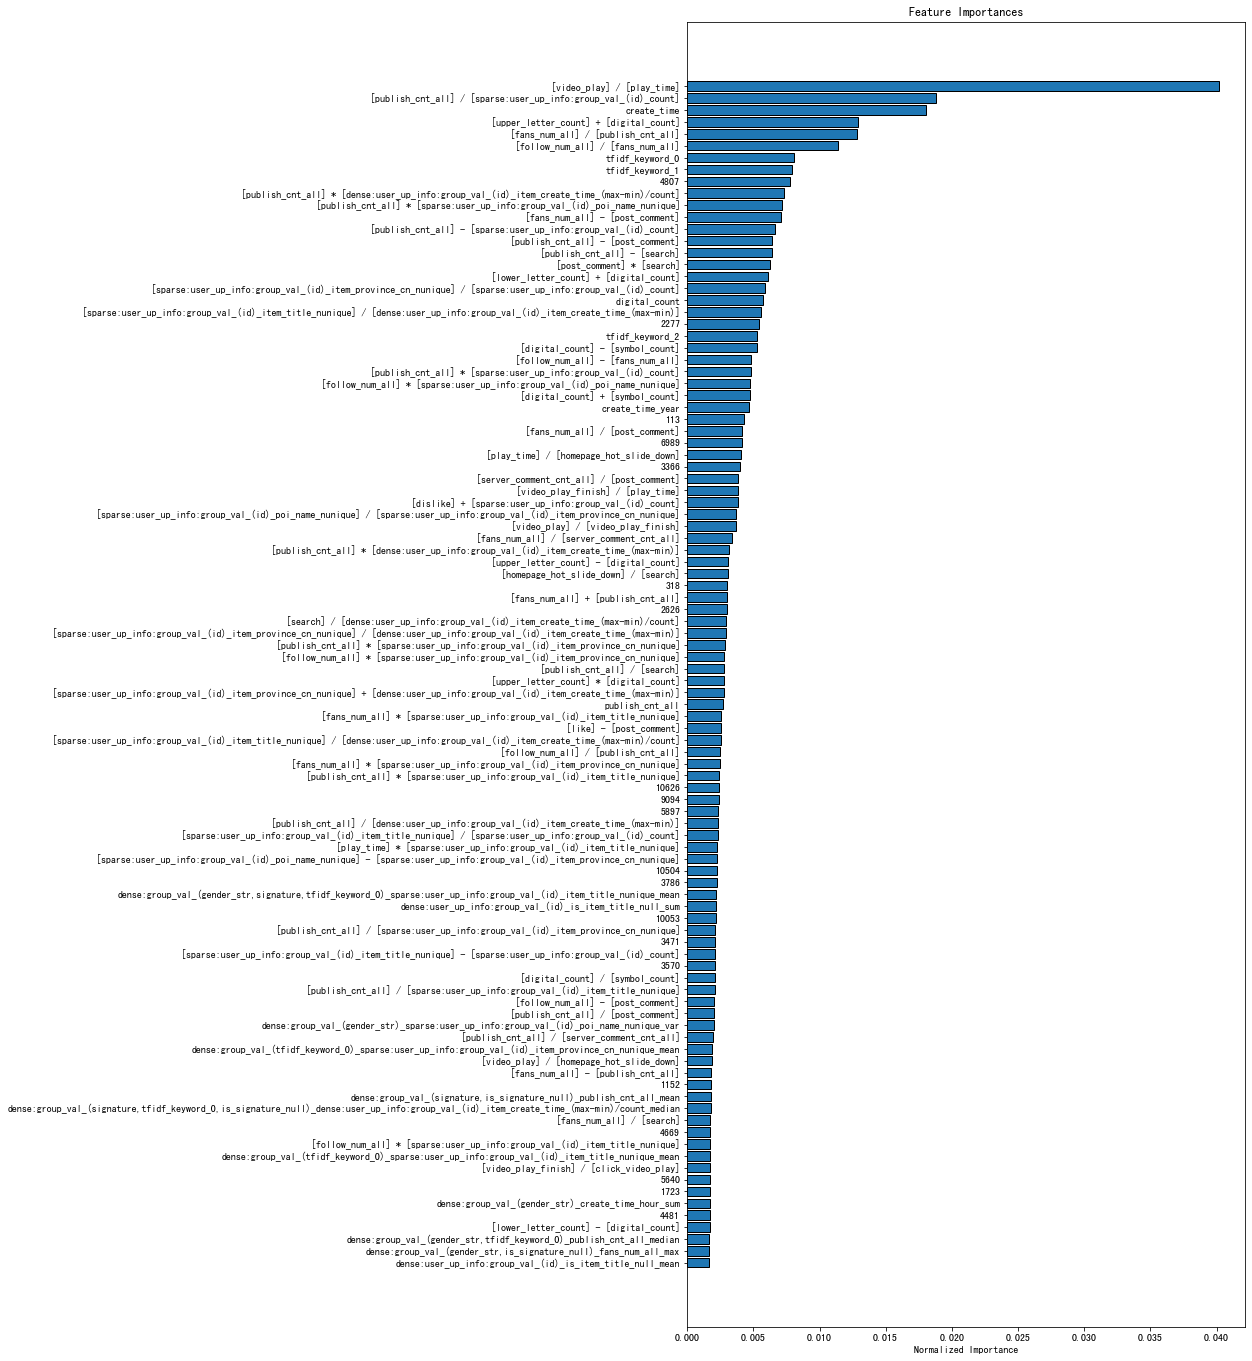

['[video_play] / [play_time]', '[publish_cnt_all] / [sparse:user_up_info:group_val_(id)_count]', 'create_time', '[upper_letter_count] + [digital_count]', '[fans_num_all] / [publish_cnt_all]', '[follow_num_all] / [fans_num_all]', 'tfidf_keyword_0', 'tfidf_keyword_1', '4807', '[publish_cnt_all] * [dense:user_up_info:group_val_(id)_item_create_time_(max-min)/count]', '[publish_cnt_all] * [sparse:user_up_info:group_val_(id)_poi_name_nunique]', '[fans_num_all] - [post_comment]', '[publish_cnt_all] - [sparse:user_up_info:group_val_(id)_count]', '[publish_cnt_all] - [post_comment]', '[publish_cnt_all] - [search]', '[post_comment] * [search]', '[lower_letter_count] + [digital_count]', '[sparse:user_up_info:group_val_(id)_item_province_cn_nunique] / [sparse:user_up_info:group_val_(id)_count]', 'digital_count', '[sparse:user_up_info:group_val_(id)_item_title_nunique] / [dense:user_up_info:group_val_(id)_item_create_time_(max-min)]', '2277', 'tfidf_keyword_2', '[digital_count] - [symbol_count]', 

In [133]:
def plot_feature_importances(df, top_k=15):
    
    df = df.sort_values('importance', ascending = False).reset_index()

    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    plt.figure(figsize = (10, 24))
    ax = plt.subplot()

    ax.barh(list(reversed(list(df.index[:top_k]))), 
            df['importance_normalized'].head(top_k), 
            align = 'center', edgecolor = 'k')

    ax.set_yticks(list(reversed(list(df.index[:top_k]))))
    ax.set_yticklabels(df['feature'].head(top_k))

    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

top_k = 100
fi_sorted = plot_feature_importances(fi, top_k=top_k)
important_features = [x for x in fi_sorted['feature'].iloc[:top_k]]
print(important_features)

In [134]:
def binary_search_threshold_by_one_sum(array, one_sum):
    # 二分找符合训练集 0/1 占比的阈值（one_sum 为 1 的个数）
    low = 0
    high = 1.0
    mid = 0.0
    eps = 1e-6

    while True:
        mid = (low + high) / 2.0
        one_sum_tmp = sum(array > mid)
        
#         print(mid, one_sum_tmp)
        
        if high - low < eps:
            break

        if one_sum_tmp < one_sum:
            high = mid
        elif one_sum_tmp > one_sum:
            low = mid
        else:
            break

    return mid

### 绘制训练集中选用不同阈值下的 f-0.3 score

用于预估测试集的阈值选取

max idx: 8508, 0.9689123925381306, 8508/10803 = 0.7875590113857261
推荐训练集阈值：8508
推荐测试集阈值：0.7875590113857261 * 3748 = 2952


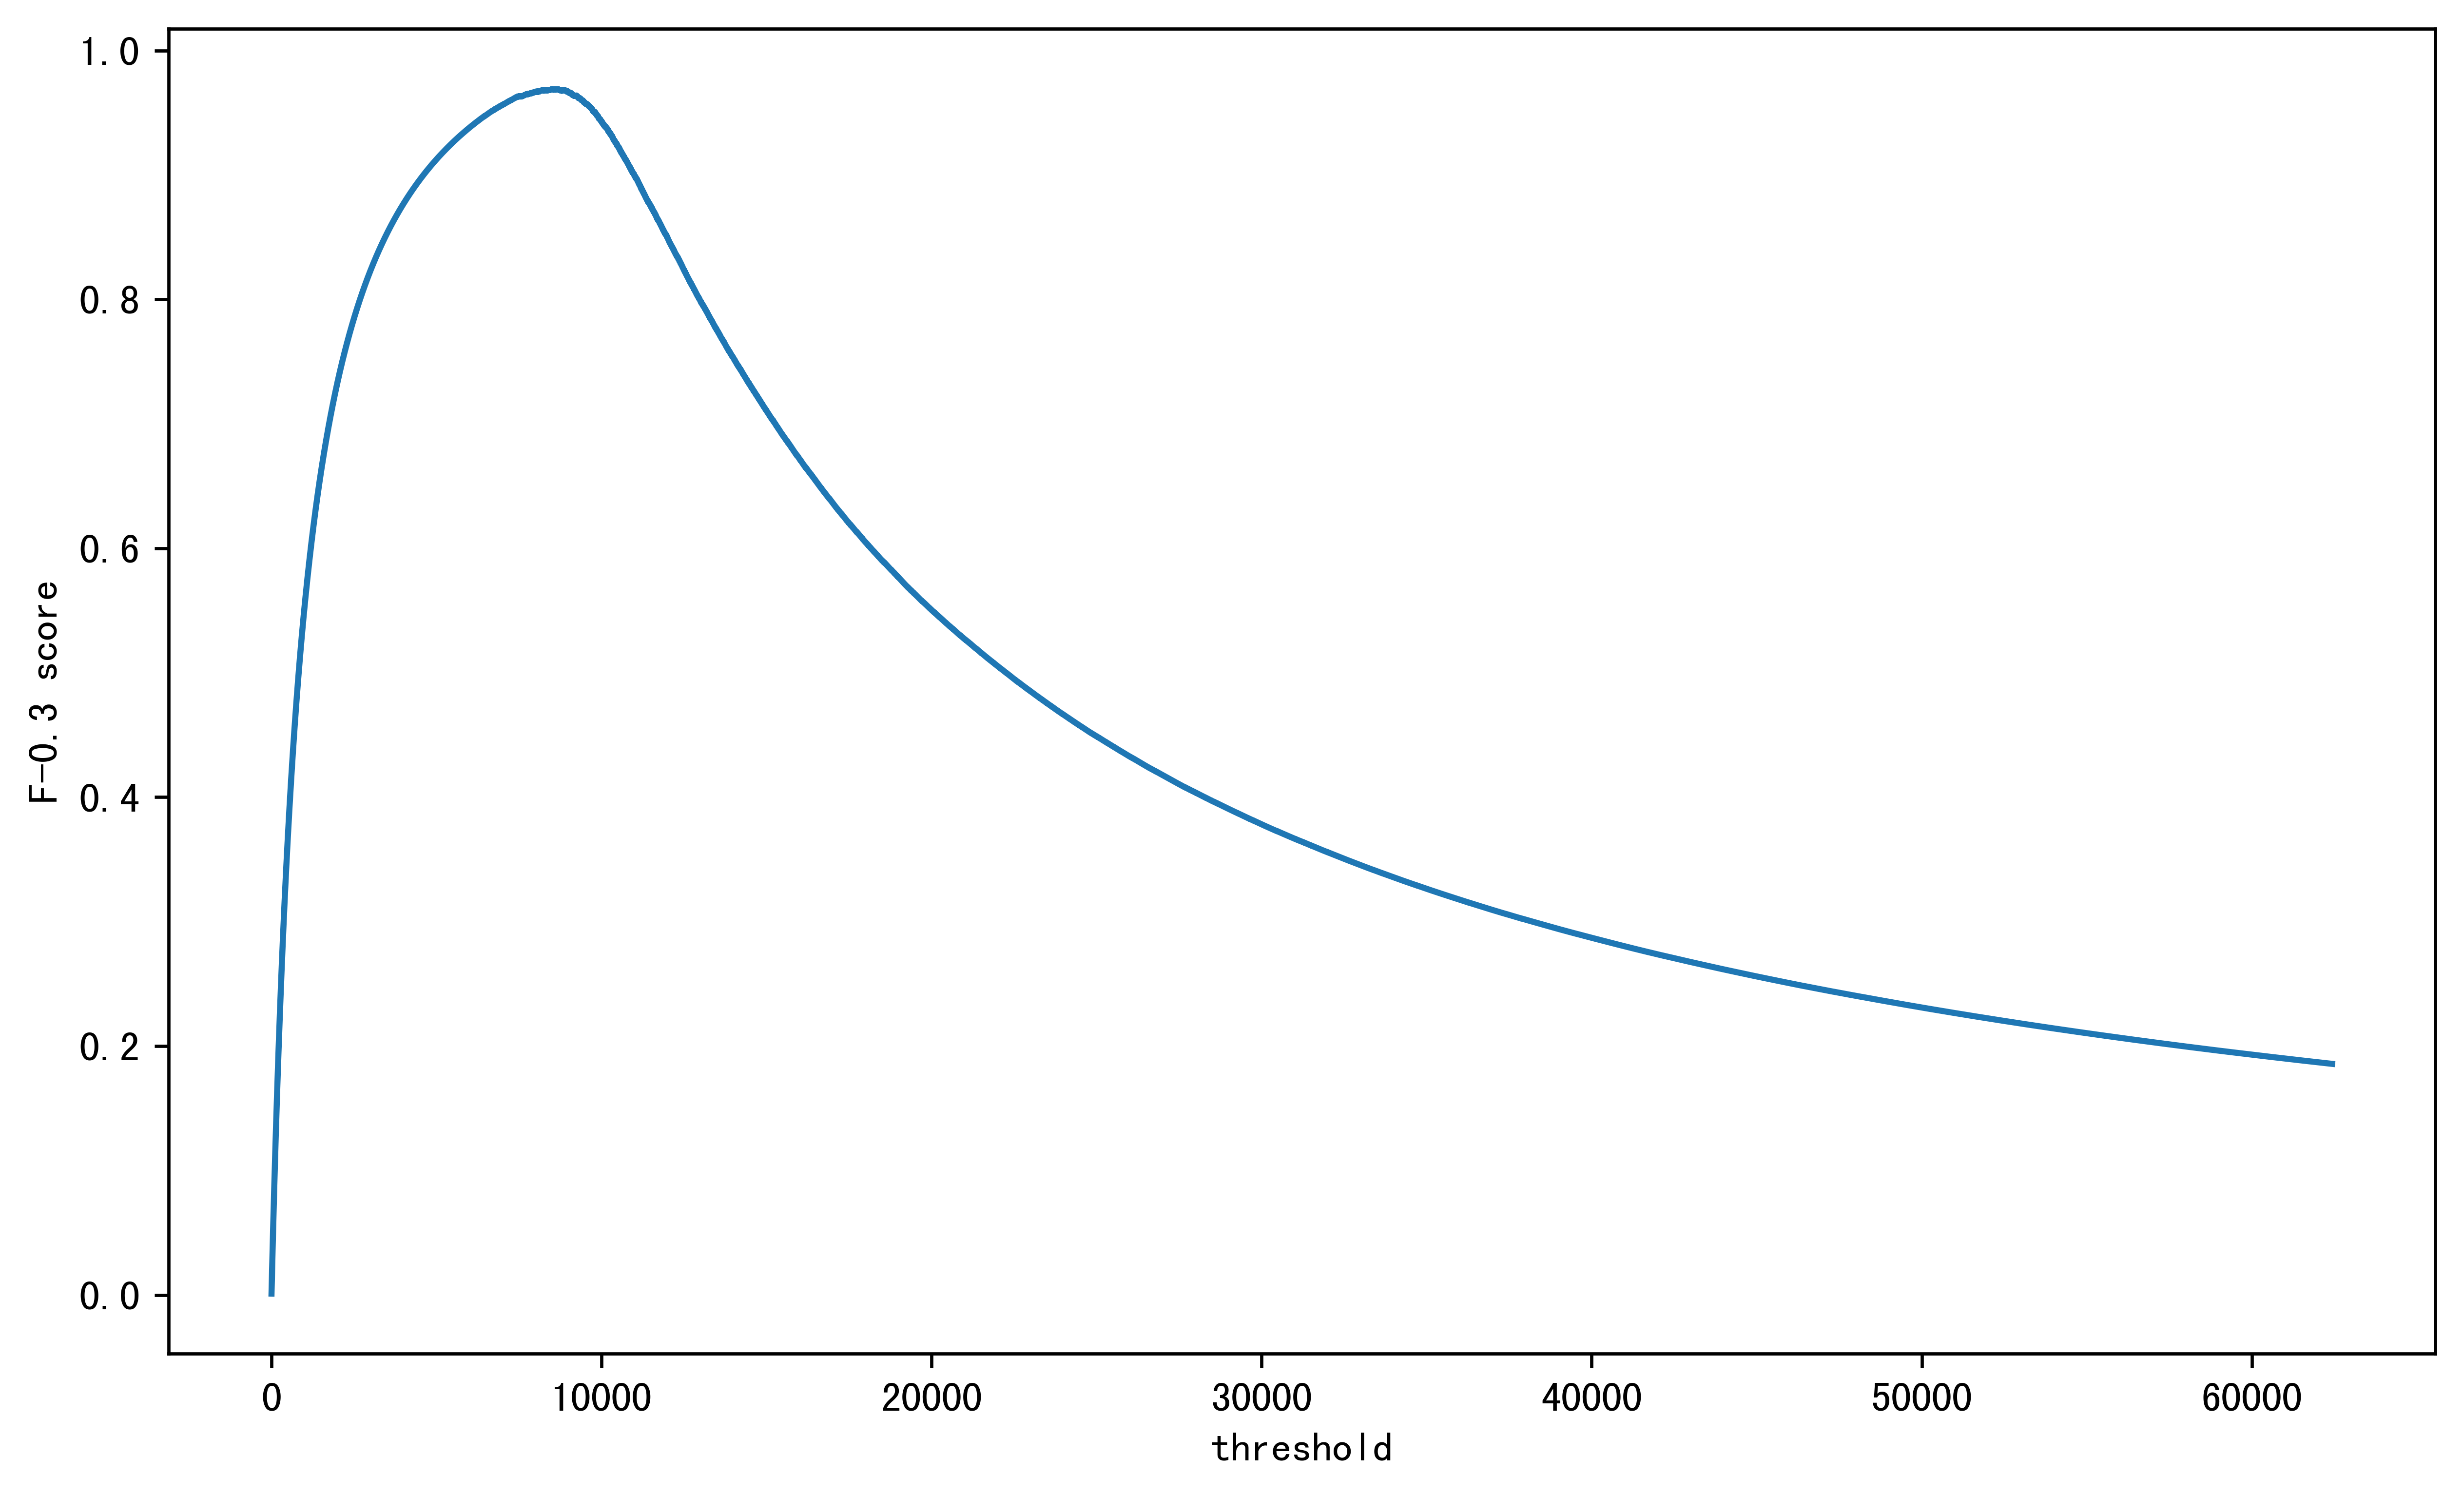

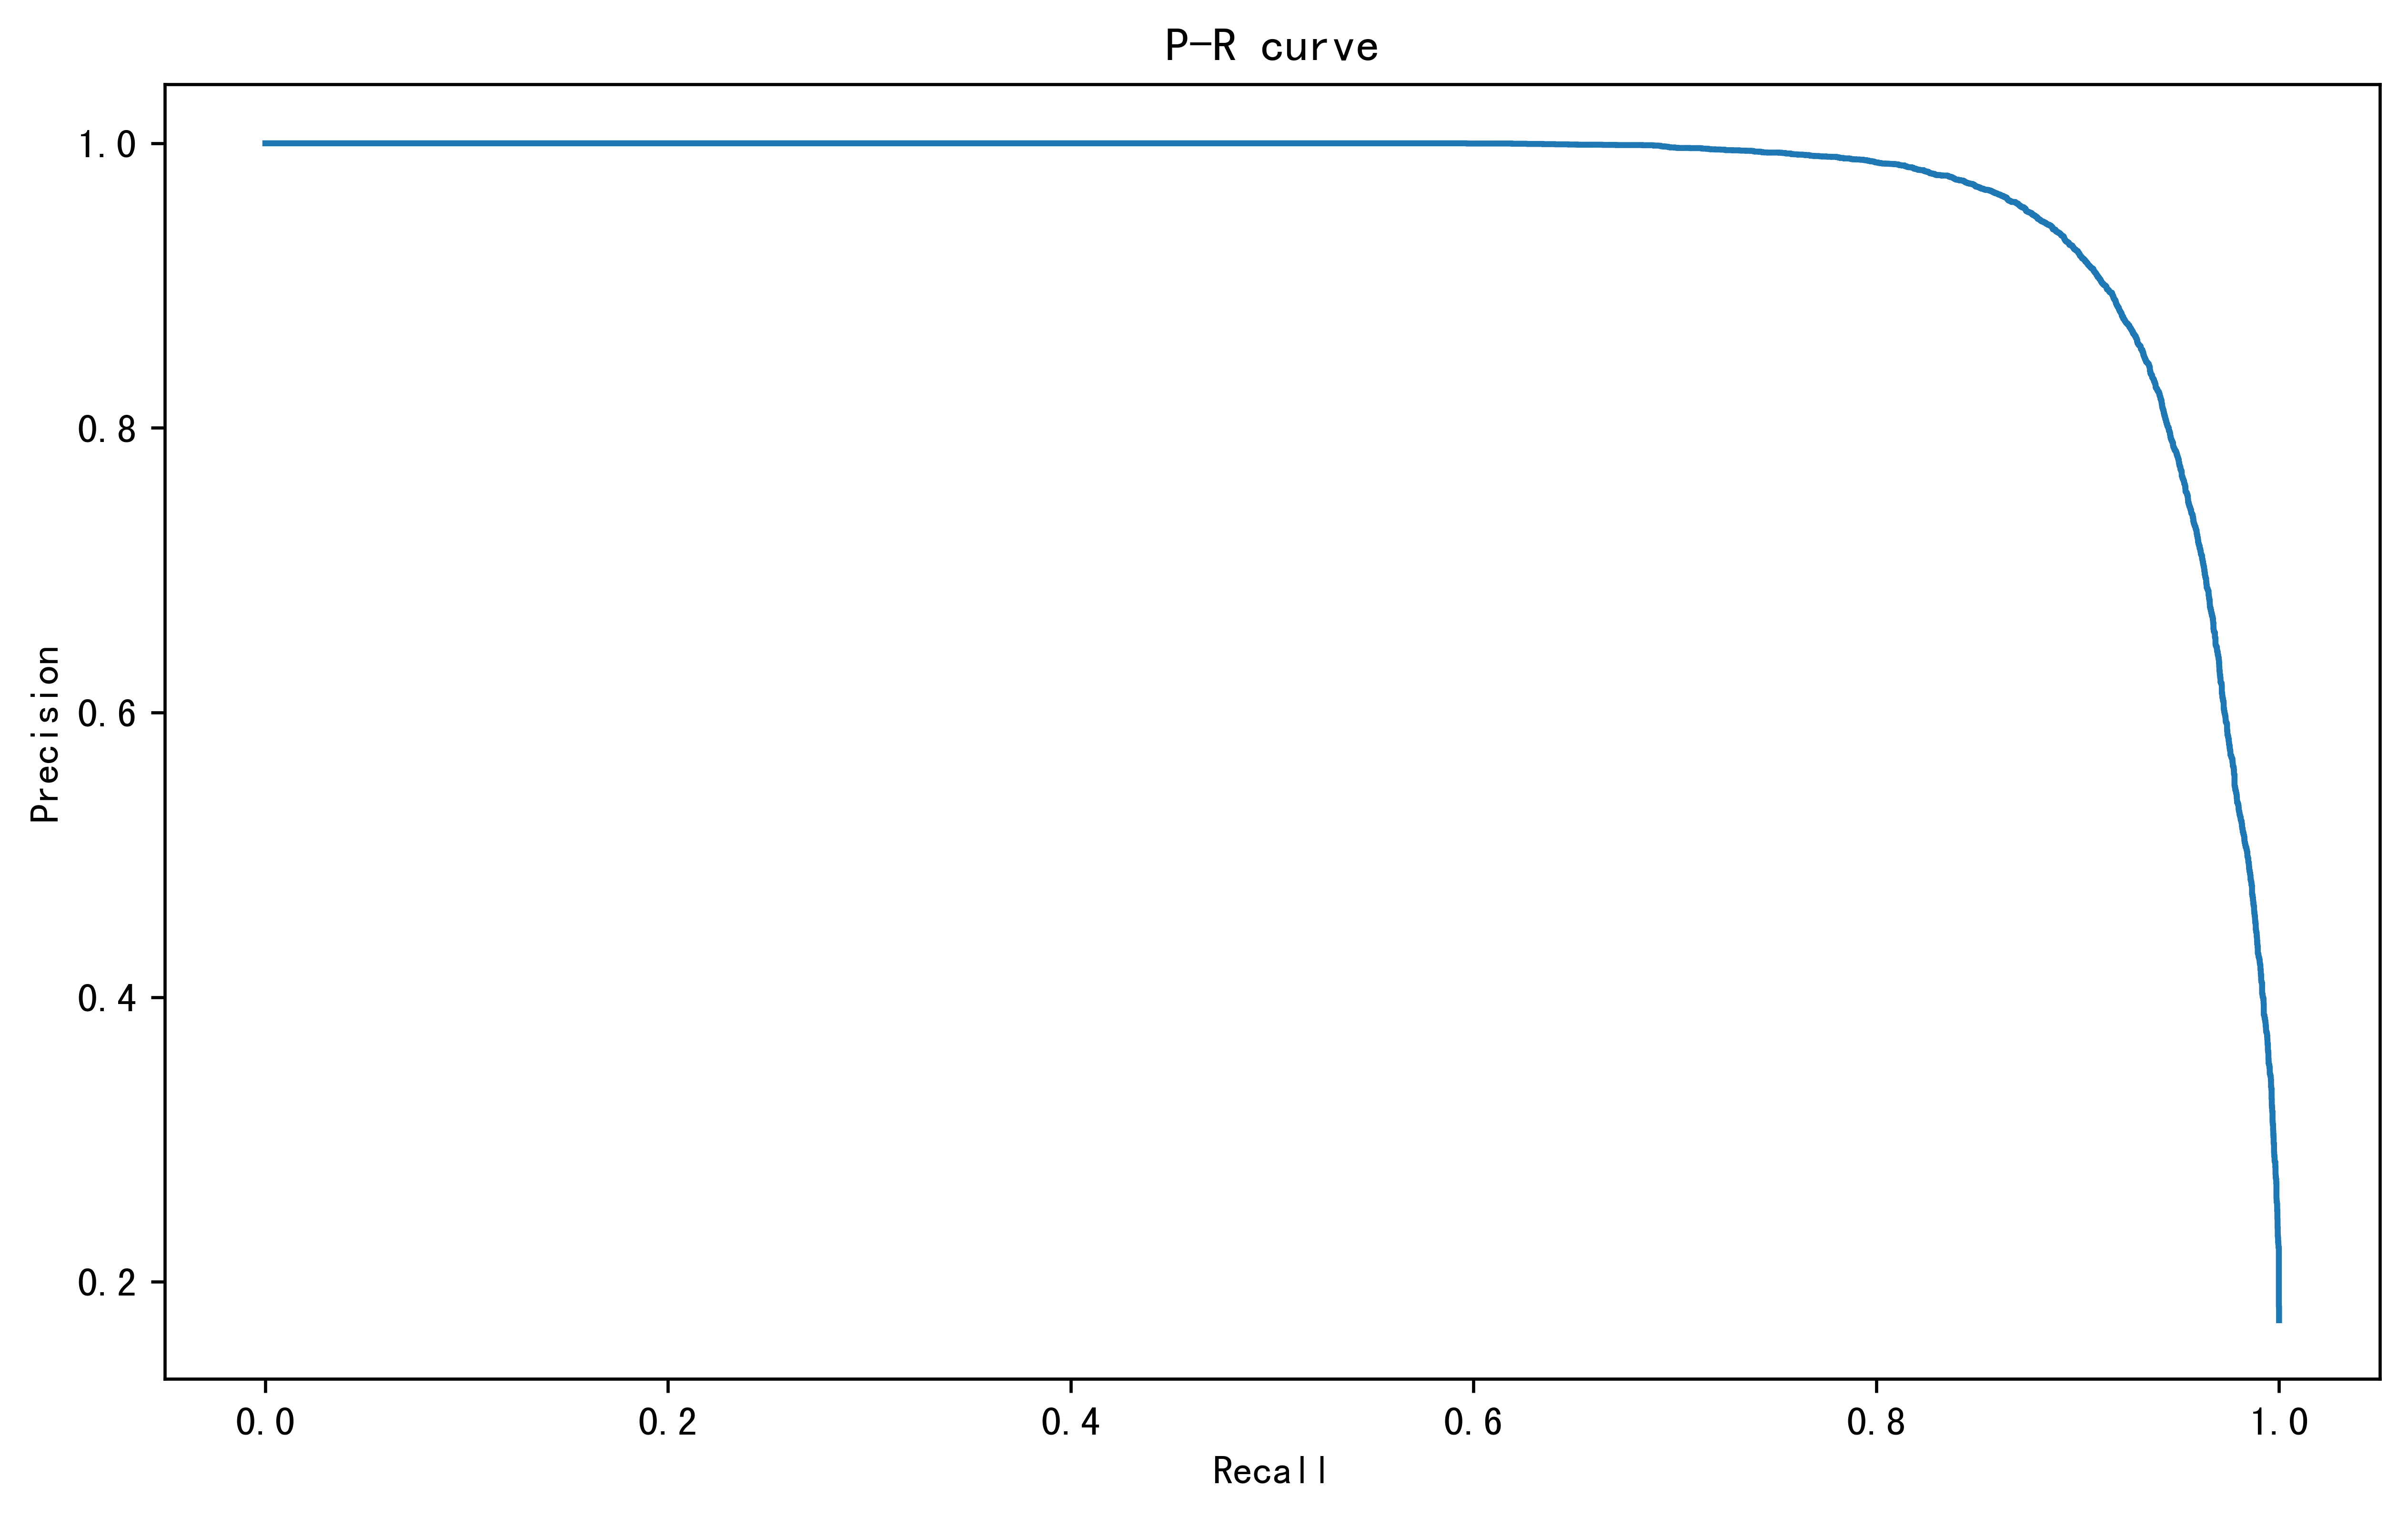

In [135]:
def get_fscore(tp, tpfp, p, beta=0.3):
    return (1 + beta ** 2) * (tp / tpfp * tp / p) / (beta ** 2 * tp / tpfp + tp / p)

train_pred_score = pd.DataFrame({'label': all_data[tr_index]['label'], 'pred_score': out_of_fold}).sort_values(by='pred_score', ascending=False).values

p = 10803    # 总的黑样本数量
tp = 0       # 答对的黑样本数量
tpfp = 0     # 预测的黑样本数量

x, y = np.arange(len(train_pred_score)), []
recall, precision = [], []
for idx, (label, pred_score) in enumerate(train_pred_score):
    # 按照评分的顺序，逐个增加阈值的数量来看评价指标
    # print(label, pred_score)
    
    if int(label) == 1:
        tp += 1
    tpfp += 1
    y.append(get_fscore(tp, tpfp, p, beta=0.3))
    
    precision.append(tp * 1.0 / tpfp)
    recall.append(tp * 1.0 / p)

max_idx = np.array(y).argmax()
recommend_test_threshold = int(np.round(x[max_idx] * 1.0 / p * 3748))
print('max idx: {}, {}, {}/{} = {}'.format(x[max_idx], y[max_idx], x[max_idx], p, x[max_idx] / p))
print('推荐训练集阈值：{}'.format(x[max_idx]))
print('推荐测试集阈值：{} * {} = {}'.format(x[max_idx] / p, 3748, recommend_test_threshold))

# 绘制验证集 F-0.3 score 随阈值的变化曲线
plt.figure(figsize=(10, 6), dpi=600)
plt.xlabel('threshold')
plt.ylabel('F-0.3 score')
plt.plot(x, y)
plt.show()

# 绘制 PR 曲线
plt.figure(figsize=(10, 6), dpi=600)
plt.title('P-R curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision)
plt.show()


In [136]:
# 输出对训练集的预测结果（以五折交叉验证做到的）
all_data_with_pred = all_data[tr_index]
all_data_with_pred['pred_score'] = out_of_fold

# 二分找符合训练集 0/1 占比的阈值
# mid = binary_search_threshold_by_one_sum(out_of_fold, 10803)
mid = x[max_idx]

print('threshold: ', mid)
all_data_with_pred['pred_label'] = (out_of_fold > mid).astype(int)

# 本地 fscore
fscore_local = lgb_fbeta_0_3(all_data_with_pred['label'], out_of_fold)[1]

save_path = os.path.join('', '../submits/round_2/{}_5_fold_pred_local({:.4f})_threshold({:.4f}).csv'.format(config['exec_time'], fscore_local, mid))
all_data_with_pred[['id', 'label', 'pred_score']].to_csv(save_path, index=False, encoding='GBK')
print('五折预测结果保存成功，{}'.format(os.path.abspath(save_path)))

save_path = '../resources/round_2/all_model_with_fi/{}_all_model_with_fi_local({:.4f}).pickle'.format(config['exec_time'], fscore_local)
PickleUtils.save_pickle((all_model, fi), save_path)
PickleUtils.save_pickle((all_model, fi), '../resources/round_2/all_model_with_fi/all_model_lastest.pickle')
print('all_model & fi 保存成功，{}'.format(os.path.abspath(save_path)))

threshold:  8508
五折预测结果保存成功，/mnt/ssd/im0qianqian/projects/ai_competition/submits/round_2/2021.11.12-08.53.41_5_fold_pred_local(0.9497)_threshold(8508.0000).csv
all_model & fi 保存成功，/mnt/ssd/im0qianqian/projects/ai_competition/resources/round_2/all_model_with_fi/2021.11.12-08.53.41_all_model_with_fi_local(0.9497).pickle


In [137]:
submit = test_features[['id']]

one_sum = recommend_test_threshold
one_sum = 2760
threshold = binary_search_threshold_by_one_sum(submission['label'].values, one_sum)

print('threshold: {}\n'.format(threshold))

# submission
submit['label'] = (submission['label'] >= threshold).astype(int)
submit['pred_score'] = submission['label']

print('训练集分布：')
print(train_user_base_info['label'].value_counts())
print(train_user_base_info['label'].value_counts() / len(train_user_base_info))

print('\n预测结果分布（阈值 {}）：'.format(threshold))
print(submit['label'].value_counts())
print(submit['label'].value_counts() / len(submit))

submit_save_path = os.path.join('', '../submits/round_2/{}_result_local({:.4f})_online(xx)_threshold({:.4f})({}).csv'.format(config['exec_time'], fscore_local, threshold, one_sum))
submit.to_csv(submit_save_path, index=False)
print('答案保存成功，{}'.format(os.path.abspath(submit_save_path)))

threshold: 0.917724609375

训练集分布：
0    51630
1    10803
Name: label, dtype: int64
0    0.826967
1    0.173033
Name: label, dtype: float64

预测结果分布（阈值 0.917724609375）：
0    42235
1     2760
Name: label, dtype: int64
0    0.93866
1    0.06134
Name: label, dtype: float64
答案保存成功，/mnt/ssd/im0qianqian/projects/ai_competition/submits/round_2/2021.11.12-08.53.41_result_local(0.9497)_online(xx)_threshold(0.9177)(2760).csv


## 以上即本次比赛所提交的结果，以下是深度学习模型的探索

### 将 id 化后的数据写入文件，供深度学习模型使用

In [29]:
features, cat_indices = category_idization(features=all_data.copy(), encoding='le')

Data Shape:  (107428, 62)
sparse column:  ['gender_str', 'signature', 'tfidf_keyword_0']
sparse column idx:  [1, 2, 57]


In [32]:
all_data

,id,gender_str,signature,create_time,follow_num_all,fans_num_all,publish_cnt_all,server_comment_cnt_all,video_play,video_play_finish,...,dense:user_up_info:group_val_(id)_is_poi_name_null_max,dense:user_up_info:group_val_(id)_is_poi_name_null_min,dense:user_up_info:group_val_(id)_is_poi_name_null_sum,dense:user_up_info:group_val_(id)_is_poi_name_null_var,dense:user_up_info:group_val_(id)_is_poi_name_null_std,tfidf_keyword_0,小写字母,大写字母,数字,符号
0,44630,male,,1546356215,115,149,6,44,1641.0,504.0,...,0.0,0.0,0.0,0.0,0.000000,385,0,0,0,0
1,45278,male,,1570359009,561,168,58,216,1762.0,44.0,...,1.0,1.0,10.0,0.0,0.000000,,0,0,0,0
2,27216,female,"890,5036,113,11018,1065,11018,113,728,4214,372...",1610200855,37,74,112,520,787.0,278.0,...,1.0,1.0,10.0,0.0,0.000000,4612,2,2,9,0
3,100024,female,"3423,498,4833,8246,4560,10729,2959,4560",1625416723,0,21,1,0,3.0,0.0,...,1.0,1.0,1.0,0.0,0.000000,4560,0,0,0,0
4,237043,female,"113,4333,8953,10690,4214,3720,4214,4333,4333,1...",1520244809,7,806,1498,693,779.0,92.0,...,1.0,1.0,10.0,0.0,0.000000,4333,0,0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107423,137771,female,"8382,7053,1035,6594,7012",1566734517,1999,1152,292,6575,247.0,83.0,...,1.0,1.0,10.0,0.0,0.000000,4612,0,0,0,0
107424,94864,female,"113,4214,4214,113,11018,728,1065,728,5324,1065",1543319037,1358,579,2408,15788,16874.0,914.0,...,1.0,1.0,10.0,0.0,0.000000,4214,0,1,9,0
107425,6285,female,"4857,1117,2574,10086,301,5864,4552,5132,9782,3...",1499176652,135,377,1571,335,207.0,58.0,...,1.0,1.0,10.0,0.0,0.000000,301,0,0,11,0
107426,20581,male,"8342,2435,4870,6141,301,4552,8015,5735,8389,0,...",1522723423,178,66,318,570,2660.0,727.0,...,0.0,0.0,0.0,0.0,0.000000,2435,1,0,11,0


In [83]:
all_data['gender_str'].value_counts()

female     79210
male       27800
unknown      418
Name: gender_str, dtype: int64

In [81]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

tr_index = all_data['label'] != -1

tmp_all_data = all_data.copy()
tmp_all_data, cat_indices = category_idization(features=tmp_all_data.copy().drop(columns=['signature']), encoding='le')
cat_num_list = tmp_all_data[cat_indices].max().values + 1

tmp_all_data['signature'] = all_data['signature'].fillna('').map(lambda x: list(map(int, x.split(','))) if len(x.strip()) > 0 else [11141])

# 归一化连续列
dense_indices = list(set(tmp_all_data.columns) - set(cat_indices) - {'id', 'signature', 'label'})
mms = MinMaxScaler(feature_range=(0, 1))
tmp_all_data[dense_indices] = mms.fit_transform(tmp_all_data[dense_indices])

train_x = tmp_all_data[tr_index].drop(columns=['label'])
train_y = tmp_all_data[tr_index]['label']
test_x = tmp_all_data[~tr_index].drop(columns=['label'])

save_path = '../resources/round_2/all_data_with_idization.pickle'
PickleUtils.save_pickle({
    'train_x': train_x,
    'train_y': train_y,
    'test_x': test_x,
    'cat_indices': cat_indices,
    'cat_num_list': cat_num_list,
    'dense_indices': dense_indices,
    'seq_indices': ['signature'],
}, save_path)
tmp_all_data

Data Shape:  (107428, 61)
sparse column:  ['gender_str', 'tfidf_keyword_0']
sparse column idx:  [1, 56]


,id,gender_str,create_time,follow_num_all,fans_num_all,publish_cnt_all,server_comment_cnt_all,video_play,video_play_finish,play_time,...,dense:user_up_info:group_val_(id)_is_poi_name_null_min,dense:user_up_info:group_val_(id)_is_poi_name_null_sum,dense:user_up_info:group_val_(id)_is_poi_name_null_var,dense:user_up_info:group_val_(id)_is_poi_name_null_std,tfidf_keyword_0,小写字母,大写字母,数字,符号,signature
0,44630,1,0.433823,0.011431,0.000012,0.000015,0.000235,0.007495,0.006849,0.007514,...,0.0,0.0,0.0,0.000000,2139,0.000000,0.000000,0.000000,0.0,[11141]
1,45278,1,0.593838,0.055765,0.000013,0.000142,0.001154,0.008048,0.000598,0.009043,...,1.0,1.0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.0,[11141]
2,27216,0,0.859443,0.003678,0.000006,0.000275,0.002777,0.003595,0.003778,0.004362,...,1.0,1.0,0.0,0.000000,2568,0.011561,0.018182,0.093750,0.0,"[890, 5036, 113, 11018, 1065, 11018, 113, 728,..."
3,100024,0,0.960880,0.000000,0.000002,0.000002,0.000000,0.000014,0.000000,0.000013,...,1.0,0.1,0.0,0.000000,2533,0.000000,0.000000,0.000000,0.0,"[3423, 498, 4833, 8246, 4560, 10729, 2959, 4560]"
4,237043,0,0.259751,0.000696,0.000064,0.003679,0.003701,0.003558,0.001250,0.003886,...,1.0,1.0,0.0,0.000000,2412,0.000000,0.000000,0.104167,0.0,"[113, 4333, 8953, 10690, 4214, 3720, 4214, 433..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107423,137771,0,0.569675,0.198708,0.000092,0.000717,0.035116,0.001128,0.001128,0.001223,...,1.0,1.0,0.0,0.000000,2568,0.000000,0.000000,0.000000,0.0,"[8382, 7053, 1035, 6594, 7012]"
107424,94864,0,0.413575,0.134990,0.000046,0.005913,0.084322,0.077072,0.012421,0.076482,...,1.0,1.0,0.0,0.000000,2349,0.000000,0.009091,0.093750,0.0,"[113, 4214, 4214, 113, 11018, 728, 1065, 728, ..."
107425,6285,0,0.119300,0.013419,0.000030,0.003858,0.001789,0.000945,0.000788,0.001072,...,1.0,1.0,0.0,0.000000,1661,0.000000,0.000000,0.114583,0.0,"[4857, 1117, 2574, 10086, 301, 5864, 4552, 513..."
107426,20581,1,0.276275,0.017694,0.000005,0.000781,0.003044,0.012150,0.009880,0.013356,...,0.0,0.0,0.0,0.000000,1338,0.005780,0.000000,0.114583,0.0,"[8342, 2435, 4870, 6141, 301, 4552, 8015, 5735..."


In [80]:
tmp_all_data[dense_indices]

,feed_request,create_time,dense:user_up_info:group_val_(id)_is_item_title_null_mean,create_time_month,dense:user_up_info:group_val_(id)_item_create_time_var,sparse:user_up_info:group_val_(id)_poi_name_nunique,dense:user_up_info:group_val_(id)_is_item_title_null_var,dense:user_up_info:group_val_(id)_is_poi_name_null_sum,dense:user_up_info:group_val_(id)_item_create_time_std,符号,...,server_comment_cnt_all,create_time_day,click_video_play,dense:user_up_info:group_val_(id)_is_item_title_null_min,post_comment,dense:user_up_info:group_val_(id)_is_item_title_contain_url_mean,video_play_finish,publish_cnt_all,dense:user_up_info:group_val_(id)_item_create_time_(max-min)/count,create_time_hour
0,0.0,0.433823,0.0,0.000000,0.000000,0.1,0.000000,0.0,0.000000,0.0,...,0.000235,0.000000,0.002651,0.0,0.000000,0.0,0.006849,0.000015,0.000000,0.652174
1,0.0,0.593838,1.0,0.818182,0.045695,0.1,0.000000,1.0,0.213763,0.0,...,0.001154,0.166667,0.015907,1.0,0.000139,0.0,0.000598,0.000142,0.075369,0.434783
2,0.0,0.859443,0.1,0.000000,0.122757,0.1,0.200000,1.0,0.350366,0.0,...,0.002777,0.266667,0.009705,0.0,0.000418,0.0,0.003778,0.000275,0.144359,0.608696
3,0.0,0.960880,1.0,0.545455,0.000000,0.1,0.000000,0.1,0.000000,0.0,...,0.000000,0.100000,0.000000,1.0,0.000000,0.0,0.000000,0.000002,0.000000,0.695652
4,0.0,0.259751,1.0,0.181818,0.001869,0.1,0.000000,1.0,0.043232,0.0,...,0.003701,0.133333,0.005113,1.0,0.000000,0.0,0.001250,0.003679,0.015439,0.434783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107423,0.0,0.569675,0.2,0.636364,0.070370,0.1,0.355556,1.0,0.265274,0.0,...,0.035116,0.800000,0.000379,0.0,0.001813,0.0,0.001128,0.000717,0.110860,0.521739
107424,0.0,0.413575,1.0,0.909091,0.000114,0.1,0.000000,1.0,0.010697,0.0,...,0.084322,0.866667,0.024476,1.0,0.059266,0.0,0.012421,0.005913,0.003653,0.478261
107425,0.0,0.119300,0.2,0.545455,0.014168,0.1,0.355556,1.0,0.119031,0.0,...,0.001789,0.100000,0.001988,0.0,0.000139,0.0,0.000788,0.003858,0.050026,0.565217
107426,0.0,0.276275,0.0,0.272727,0.019452,0.1,0.000000,0.0,0.139469,0.0,...,0.003044,0.066667,0.005208,0.0,0.000139,0.0,0.009880,0.000781,0.058274,0.086957


In [45]:
max_idx = 0
for i in tmp_all_data['signature']:
    for j in i:
        max_idx = max(max_idx, int(j))
max_idx

11140

In [59]:
a = train_user_up_info['poi_name'].fillna('').map(lambda x: x.split(',') if len(x.strip()) > 0 else [])

for i in a:
    for j in i:
        max_idx = max(max_idx, int(j))
max_idx

11140

In [64]:
test_user_up_info

,id,item_title,poi_name,item_province_cn,item_create_time
0,90344,"5255,4580,55,8065,4580,6675,859,1439,2314,1240...",NaN,安徽,1631249103
1,90344,"7841,133,7708,7012,133,6694,2809,3471,55,5044,...",NaN,浙江,1631026725
2,90344,"8454,9780,9210,9094,10261,5691,8048,3396,5894,...",NaN,浙江,1630763480
3,90344,"6747,1868,7012,1238,6039,55,5395,1903,7360,55,...",NaN,浙江,1630565121
4,90344,"4424,7452,4599,9210,9094,7543,81,10832,1152,75...",NaN,浙江,1630495587
...,...,...,...,...,...
362750,274507,"4612,1039,1039,10941,9210,3630,2593,3672",NaN,安徽,1631111853
362751,274507,NaN,NaN,安徽,1631072037
362752,274507,NaN,NaN,安徽,1631057439
362753,274507,NaN,NaN,安徽,1631011235
